# MAP-Elites track generations

In [11]:
import numpy as np
import requests
import random
import matplotlib.pyplot as plt
import glob, os
import joblib    
# Just load a saved t-SNE or UMAP model     
EMBEDDING_MODEL = joblib.load("embedding/umap_model.joblib")   # 2-D model trained offline


from ribs.archives import SlidingBoundariesArchive
from ribs.emitters import EmitterBase
from ribs.schedulers import Scheduler
from dask.distributed import Client, LocalCluster, as_completed
from ribs.visualize import sliding_boundaries_archive_heatmap


In [12]:
BASE_URL = 'http://localhost:4242'
GENERATION_MODE = 'convexHull' #'convexHull' or 'voronoi'
POINTS_COUNT = 100
MAX_SELECTED_CELLS = 10
SOLUTION_DIM = POINTS_COUNT * 2 + MAX_SELECTED_CELLS * 2 + 1 
TRACK_SIZE_RANGE = (100,100) #(4, 10)
LENGTH_RANGE = (400, 2000)
ITERATIONS = 1000
ARCHIVE_DIM = 10
INIT_POPULATION = ARCHIVE_DIM * ARCHIVE_DIM 

BATCH_SIZE=15

INVALID_SCORE    = -1e9
CHECKPOINT_EVERY = 50

DEBUG_CROSSOVER = True
DEBUG_MUTATION = True


ARCHIVE_BINS = 30                               # cells per axis
REMAPPING_EVERY = 200                           # move boundaries every 200 insertions
BUFFER_SIZE = 1000                              # keep last 1000 solutions

In [13]:
cluster = LocalCluster(processes=True, n_workers=BATCH_SIZE, threads_per_worker=1)
client = Client(cluster)

c:\Users\batman\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54767 instead
  warnings.warn(


### Helper functions

In [14]:
def generate_solution(iteration):
    print(f"Generating solution for iteration {iteration}")
    try:
        response = requests.post(
            f"{BASE_URL}/generate",
            json={
                "id": iteration + random.random(),
                "mode": GENERATION_MODE,
                "trackSize": random.randint(TRACK_SIZE_RANGE[0], TRACK_SIZE_RANGE[1])
            },
            timeout=60
        )
        response.raise_for_status()
        return response.json()
    except requests.RequestException as e:
        print(f"Error generating solution for iteration {iteration}: {e}")
        return None

def solution_to_array(sol):
    if sol is None:
        return None
    arr = np.zeros(SOLUTION_DIM)
    for i, p in enumerate(sol.get("dataSet", [])):
        arr[i * 2] = p.get("x", 0)
        arr[i * 2 + 1] = p.get("y", 0)
    for i, c in enumerate(sol.get("selectedCells", [])):
        if i < MAX_SELECTED_CELLS:
            idx = POINTS_COUNT * 2 + i * 2
            arr[idx] = c.get("x", 0)
            arr[idx + 1] = c.get("y", 0)
    arr[-1] = sol.get("id", 0)
    return arr

def array_to_solution(arr):
    ds = []
    for i in range(0, POINTS_COUNT * 2, 2):
        ds.append({"x": float(arr[i]), "y": float(arr[i+1])})
    sel = []
    for i in range(POINTS_COUNT * 2, SOLUTION_DIM - 1, 2):
        x_val = arr[i]
        y_val = arr[i+1]
        if x_val != 0 or y_val != 0:
            sel.append({"x": float(x_val), "y": float(y_val)})
    return {
        "id": float(arr[-1]),
        "mode": GENERATION_MODE,
        "dataSet": ds,
        "selectedCells": sel
    }

def get_fractional_part(x):
    return x - int(x)

def pca_align(points):
    pts = points - points.mean(0)
    u, _, _ = np.linalg.svd(pts, full_matrices=False)
    angle = np.arctan2(u[1, 0], u[0, 0])
    rot = np.array([[np.cos(-angle), -np.sin(-angle)],
                    [np.sin(-angle),  np.cos(-angle)]])
    aligned = pts @ rot.T
    if aligned[0, 0] < 0:
        aligned[:, 0] *= -1
    return aligned

def descriptor_from_track(sol):
    pts = np.array([[p["x"], p["y"]] for p in sol.get("splineVector", [])], dtype=float)
    aligned = pca_align(pts)
    flat = aligned.ravel()
    return EMBEDDING_MODEL.transform(flat[None, :])[0]

def fitness_formula(fit):
    l  = fit["length"]
    s = fit["straight_sections"]
    b = fit["right_bends"]
    ov = fit["total_overtakes"]
    dx = abs(fit["deltaX"])          # use magnitude only
    dx = max(dx, 1e-3)               # avoid divide-by-zero blow-ups
    return l + b*b - s*s + ov / dx

def evaluate_solution(sol):
    sol_id = sol.get("id", 0)
    ok = True
    msg = ""
    score = INVALID_SCORE
    try:
        r = requests.post(f"{BASE_URL}/evaluate", json=sol, timeout=60)
        r.raise_for_status()
        r_json = r.json()
        fit = r_json.get("fitness", {})
        score = fitness_formula(fit)
        desc = descriptor_from_track(r_json)  
    except Exception as e:
        ok = False
        msg = str(e)
        desc = np.zeros((2,))  # just in case of error

    return sol_id, ok, msg, score, desc



## Genetic operators

In [15]:
class CustomEmitter(EmitterBase):
    def __init__(self, archive, solution_dim, batch_size=BATCH_SIZE, bounds=None):
        super().__init__(archive, solution_dim=solution_dim, bounds=bounds)
        self.batch_size = batch_size
        self.iteration = 0

    def ask(self):
        self.iteration += 1
        print(f"Emitter.ask() called for iteration {self.iteration}")
        if self.iteration <= INIT_POPULATION:
            out = []
            for _ in range(self.batch_size):
                sol = generate_solution(self.iteration - 1)
                arr = solution_to_array(sol)
                if arr is not None:
                    out.append(arr)
                else:
                    out.append(np.full(SOLUTION_DIM, INVALID_SCORE))
            return np.array(out)
        else:
            if random.random() < 0.5:
                return self.mutate_solutions()
            else:
                return self.crossover_solutions()

    def mutate_solutions(self):
        print(f"Mutating solutions for iteration {self.iteration}")
        parents = self.archive.sample_elites(self.batch_size)
        out = []
        for i in range(self.batch_size):
            arr = parents["solution"][i]
            sol = array_to_solution(arr)
            try:
                response = requests.post(
                    f"{BASE_URL}/mutate",
                    json={
                        "individual": sol,
                        "intensityMutation": 10
                    },
                    timeout=60
                )
                response.raise_for_status()
                mutated = response.json().get("mutated", {})
                frac = get_fractional_part(sol["id"])
                mutated["id"] = self.iteration - 1 + frac
                mutated_arr = solution_to_array(mutated)
                if mutated_arr is not None:
                    out.append(mutated_arr)
                    print(f"Mutated ID={sol['id']} to ID={mutated['id']}")
                else:
                    out.append(np.full(SOLUTION_DIM, INVALID_SCORE))
            except requests.RequestException as e:
                print(f"Error mutating solution ID={sol['id']}: {e}")
                out.append(np.full(SOLUTION_DIM, INVALID_SCORE))
        return np.array(out)

    def crossover_solutions(self):
        print(f"Crossover solutions for iteration {self.iteration}")
        out = []
        for _ in range(self.batch_size // 2):
            try:
                while True:
                    parents = self.archive.sample_elites(2)
                    sol1 = array_to_solution(parents["solution"][0])
                    sol2 = array_to_solution(parents["solution"][1])
                    if sol1["id"] != sol2["id"]:
                        break
                response = requests.post(
                    f"{BASE_URL}/crossover",
                    json={
                        "mode": GENERATION_MODE,
                        "parent1": sol1,
                        "parent2": sol2
                    },
                    timeout=60
                )
                response.raise_for_status()
                offspring = response.json().get("offspring", {})
                f1 = get_fractional_part(sol1["id"])
                f2 = get_fractional_part(sol2["id"])
                frac = (f1 + f2) % 1
                child_id = self.iteration - 1 + frac
                child_sol = {
                    "id": child_id,
                    "mode": GENERATION_MODE,
                    "trackSize": len(offspring.get("sel", [])),
                    "dataSet": offspring.get("ds", []),
                    "selectedCells": offspring.get("sel", [])
                }
                child_arr = solution_to_array(child_sol)
                if child_arr is not None:
                    out.append(child_arr)
                    print(f"Crossover Parent1 ID={sol1['id']}, Parent2 ID={sol2['id']} => Child ID={child_id}")
                else:
                    out.append(np.full(SOLUTION_DIM, INVALID_SCORE))
            except requests.RequestException as e:
                print(f"Error during crossover: {e}")
                out.append(np.full(SOLUTION_DIM, INVALID_SCORE))
        return np.array(out)

## Illuminating search spaces by mapping elites


In [16]:
import glob
import os
import pickle

archive = SlidingBoundariesArchive(
    solution_dim=SOLUTION_DIM,
    dims=[ARCHIVE_BINS, ARCHIVE_BINS],
    ranges=[(-1, 1), (-1, 1)],
    remap_frequency=REMAPPING_EVERY,
    buffer_capacity=BUFFER_SIZE
)

emitter = CustomEmitter(
    archive,
    solution_dim=SOLUTION_DIM,
    batch_size=BATCH_SIZE,
    bounds=[(0, 600)] * (SOLUTION_DIM - 1) + [(0, float("inf"))]
)

scheduler = Scheduler(archive, [emitter])

# ──────────────────────────────────────────────────────────────
# Resume from latest pickle checkpoint if one exists
# ──────────────────────────────────────────────────────────────
checkpoints = sorted(glob.glob("checkpoint_*.pkl"))
start_iter = 0
global_best_score = INVALID_SCORE
global_best_id = None

if checkpoints:
    latest_ckpt = checkpoints[-1]
    with open(latest_ckpt, "rb") as f:
        state = pickle.load(f)
    scheduler           = state["scheduler"]
    archive  = scheduler.archive
    start_iter          = state["iteration"]
    global_best_score   = state["global_best_score"]
    global_best_id      = state["global_best_id"]
    print(f"[Resume] Loaded {latest_ckpt}, resuming from iteration {start_iter+1}")
else:
    print("[Resume] No checkpoint found — starting fresh.")


def run_map_elites(total_iters, start_iter=0):
    # declare that we mean to update these module‐level variables
    global global_best_score, global_best_id

    for i in range(start_iter, total_iters):
        print(f"=== Starting iteration {i+1} ===")
        sols      = scheduler.ask()
        sol_dicts = [array_to_solution(s) for s in sols]
        futs      = [client.submit(evaluate_solution, sol) for sol in sol_dicts]
        gathered  = [f.result() for f in as_completed(futs)]

        obj_list, clean = [], []
        for sol_id, ok, msg, score, desc in gathered:
            if not ok or not np.isfinite(score):
                print(f"Warning: clamping bad score for ID={sol_id} ({msg})")
                score = INVALID_SCORE
            else:
                print(f"Solution ID={sol_id} evaluated with score={score:.2f}")
                if score > global_best_score:
                    global_best_score = score
                    global_best_id    = sol_id
            clean.append((score, desc))
            obj_list.append(score)

        obj_batch, meas_batch = zip(*clean)
        scheduler.tell(list(obj_batch), list(meas_batch))

        batch_best = max(obj_list) if obj_list else INVALID_SCORE
        print(f"Iteration {i+1} ended. Best in batch = {batch_best:.2f}")
        print(f"Global best so far: {global_best_score:.2f} (ID={global_best_id})")

        # ── Stats ──
        data = archive.data()
        if data:
            arch_obj = data["objective"]
            valid    = arch_obj != INVALID_SCORE
            mean_val = np.mean(arch_obj[valid]) if np.any(valid) else 0.0
            best_val = np.max(arch_obj[valid]) if np.any(valid) else 0.0
            cov      = archive.stats.coverage
            print(f"Archive size={len(archive)}, cov={cov:.3f}, mean={mean_val:.2f}, best={best_val:.2f}")
        else:
            print("Archive still empty")

        # ── Checkpoint ──
        if (i + 1) % 50 == 0:
            ckpt_name = f"checkpoint_{i+1:04d}.pkl"
            with open(ckpt_name, "wb") as f:
                pickle.dump({
                    "scheduler":         scheduler,
                    "iteration":         i+1,
                    "global_best_score": global_best_score,
                    "global_best_id":    global_best_id
                }, f)
            print(f"[Checkpoint] Saved {ckpt_name}")

         # ── Plot every 5 iterations ─────────────────────────────────
        if (i + 1) % 10 == 0:
            # Pull objective array from archive data
            arch_obj = np.array(archive.data()["objective"])
            valid    = arch_obj != INVALID_SCORE

            if np.any(valid):
                # Compute percentiles to clip outliers
                p_low, p_high = np.percentile(arch_obj[valid], [20, 80])
            else:
                p_low = p_high = 0.0

            plt.figure(figsize=(8, 6))
            sliding_boundaries_archive_heatmap(
                archive,
                boundary_lw=0.5,
                vmin=p_low,
                vmax=p_high,
            )
            plt.title(f"Archive Heat-map – Iteration {i+1}")
            plt.xlabel("UMAP-1")
            plt.ylabel("UMAP-2")
            plt.tight_layout()
            plt.savefig(f"archive_heatmap_iter_{i+1}.png")
            plt.close

[Resume] No checkpoint found — starting fresh.


=== Starting iteration 1 ===
Emitter.ask() called for iteration 1
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Generating solution for iteration 0
Solution ID=0.5719414909560545 evaluated with score=966.87
Solution ID=0.37087511927946093 evaluated with score=875.81
Solution ID=0.7244689631341222 evaluated with score=811.58
Solution ID=0.7556797129860049 evaluated with score=266.90
Solution ID=0.057215485092491636 evaluated with score=724.90
Solution ID=0.8678887693050487 evaluated with score=926.75
Solution ID=0.5875746625368549 evalua

C:\Users\batman\AppData\Local\Temp\ipykernel_15528\325989919.py:111: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8, 6))


=== Starting iteration 211 ===
Emitter.ask() called for iteration 211
Mutating solutions for iteration 211
Mutated ID=111.96989869562714 to ID=210.96989869562714
Mutated ID=169.3718118233736 to ID=210.3718118233736
Mutated ID=142.7480995427343 to ID=210.7480995427343
Mutated ID=121.48037169880608 to ID=210.4803716988061
Mutated ID=136.04218599125838 to ID=210.04218599125838
Mutated ID=194.7480995427343 to ID=210.7480995427343
Mutated ID=33.972191515148964 to ID=210.97219151514895
Mutated ID=114.69617852396068 to ID=210.69617852396067
Mutated ID=114.52584436910938 to ID=210.5258443691094
Mutated ID=194.7480995427343 to ID=210.7480995427343
Mutated ID=166.22613488367608 to ID=210.22613488367608
Mutated ID=199.73976739101033 to ID=210.73976739101033
Mutated ID=73.99129264061762 to ID=210.99129264061762
Mutated ID=197.490821159573 to ID=210.490821159573
Mutated ID=206.6299326236068 to ID=210.6299326236068
Solution ID=210.96989869562714 evaluated with score=529.91
Solution ID=210.6961785239

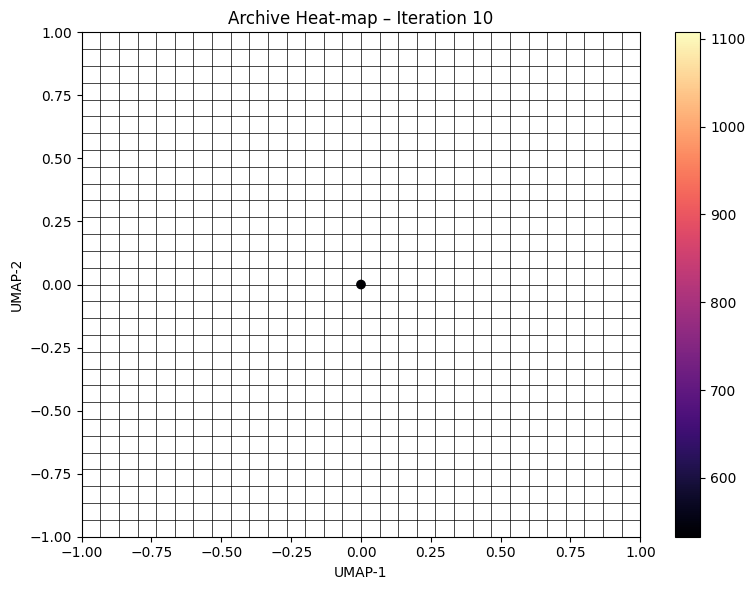

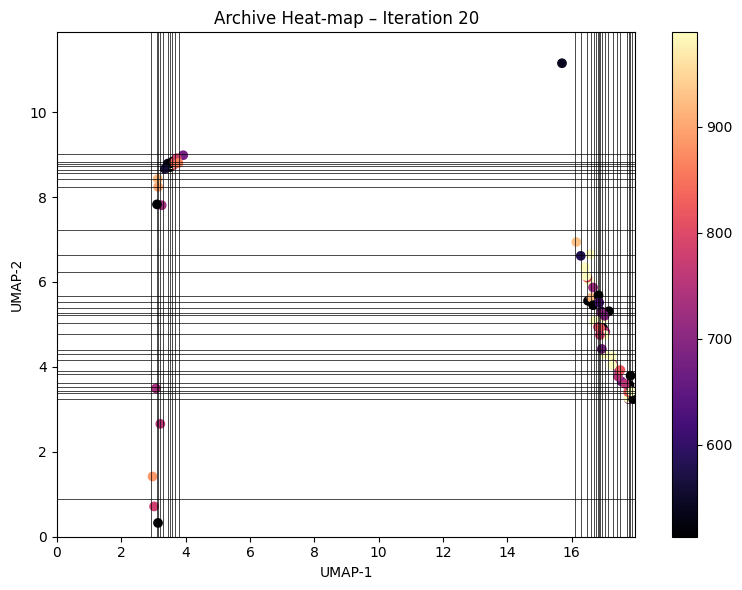

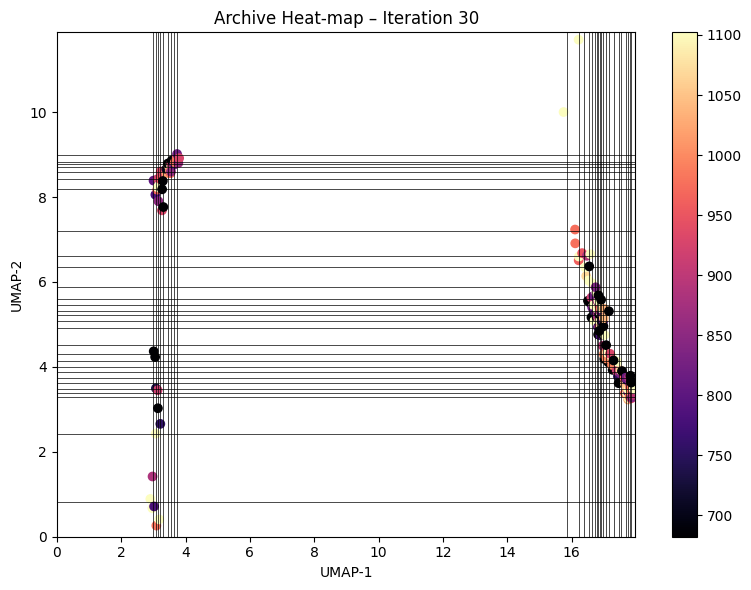

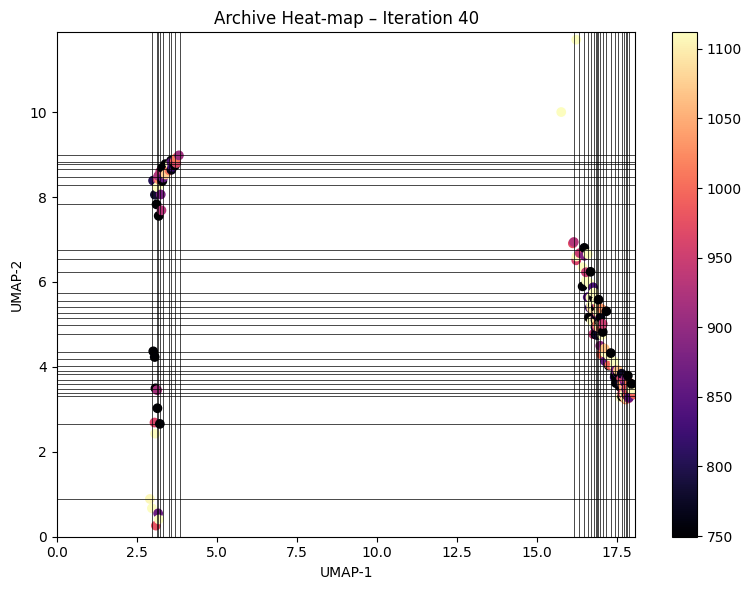

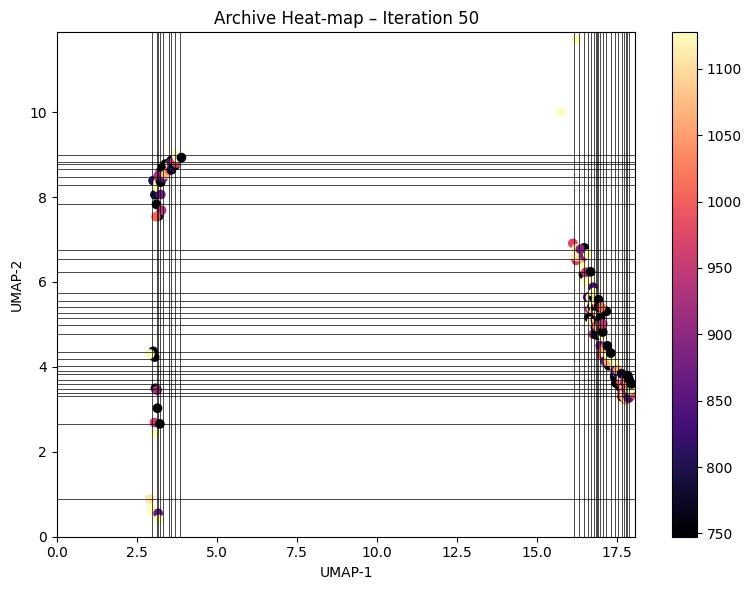

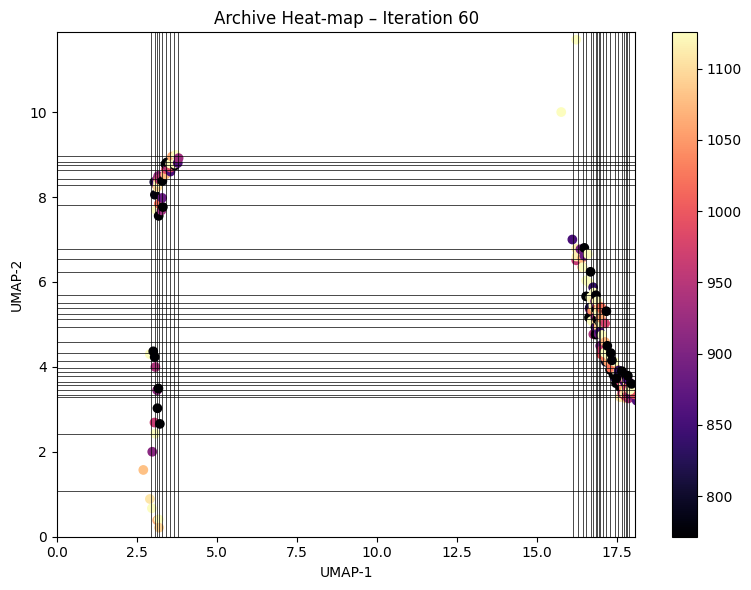

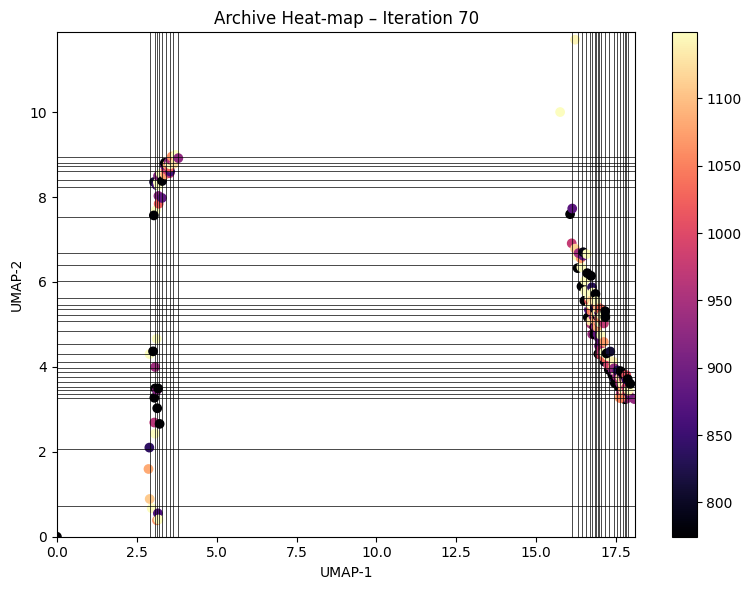

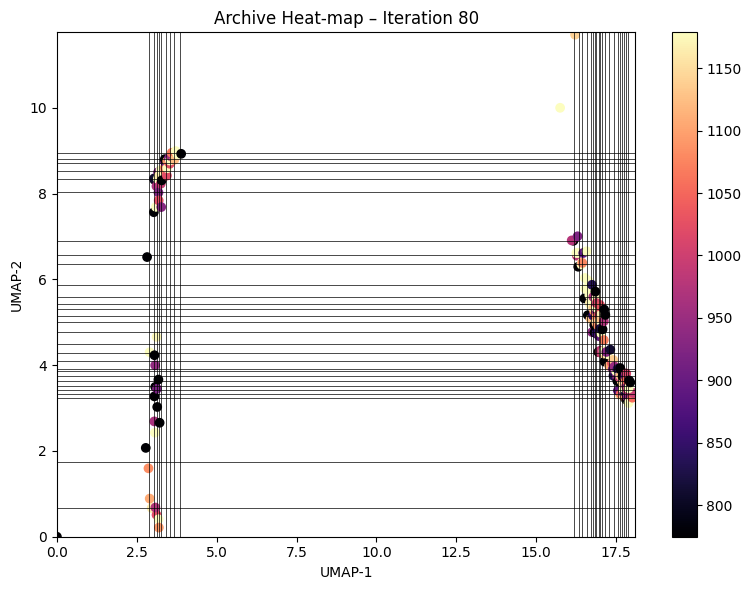

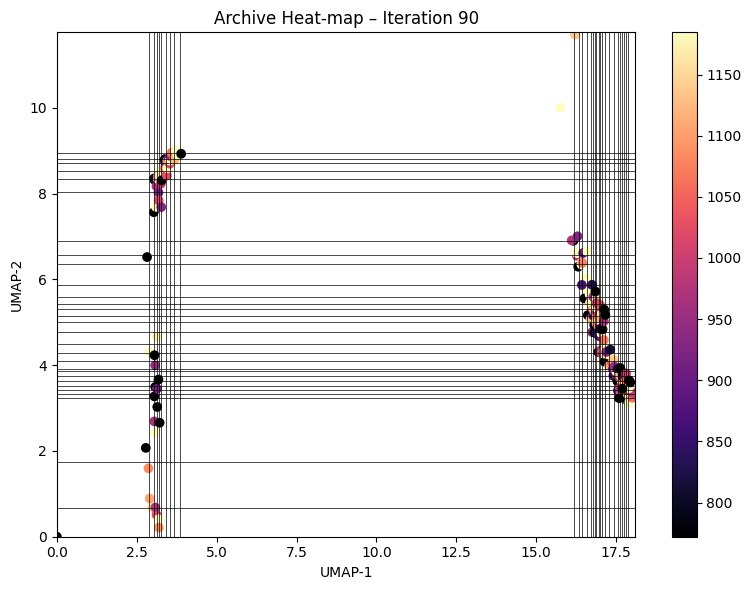

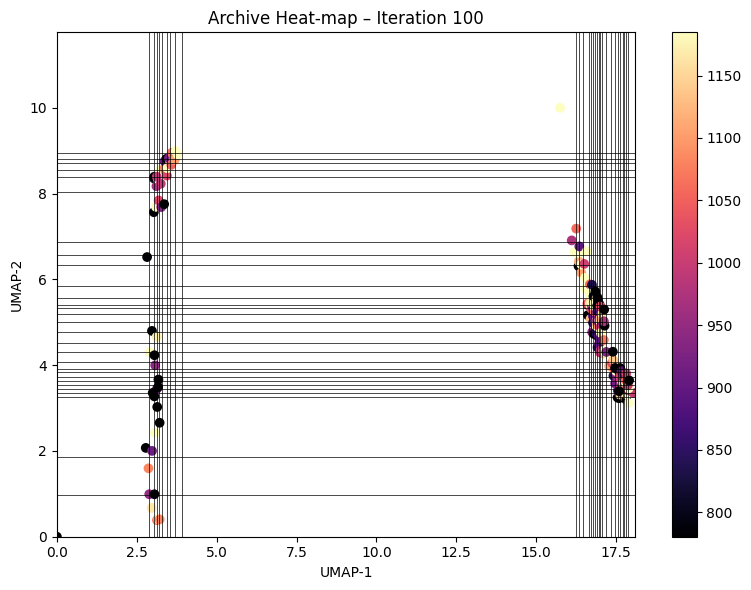

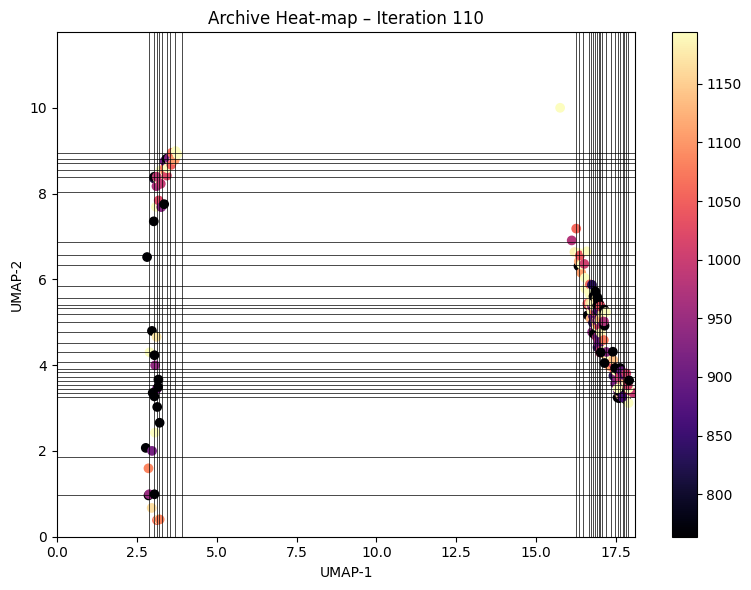

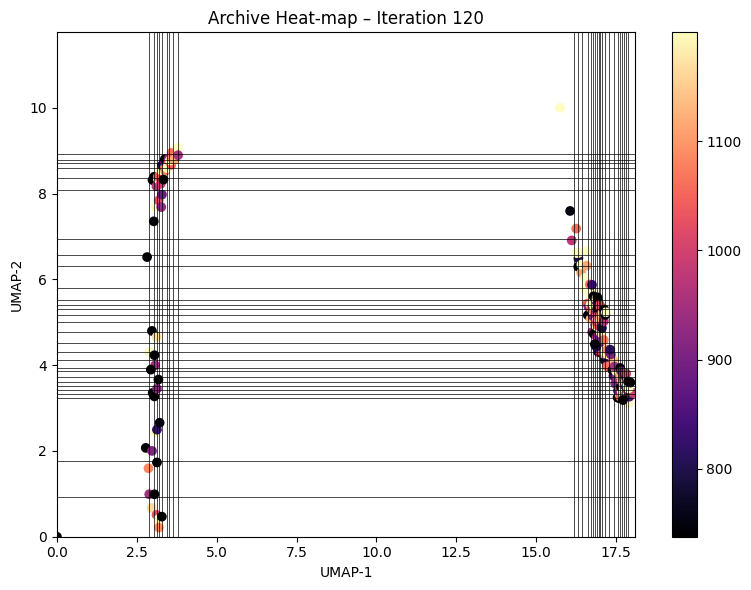

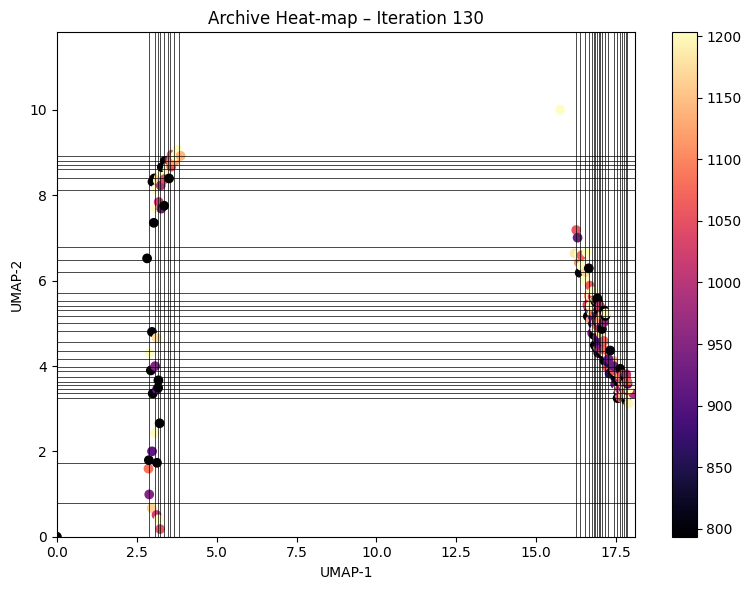

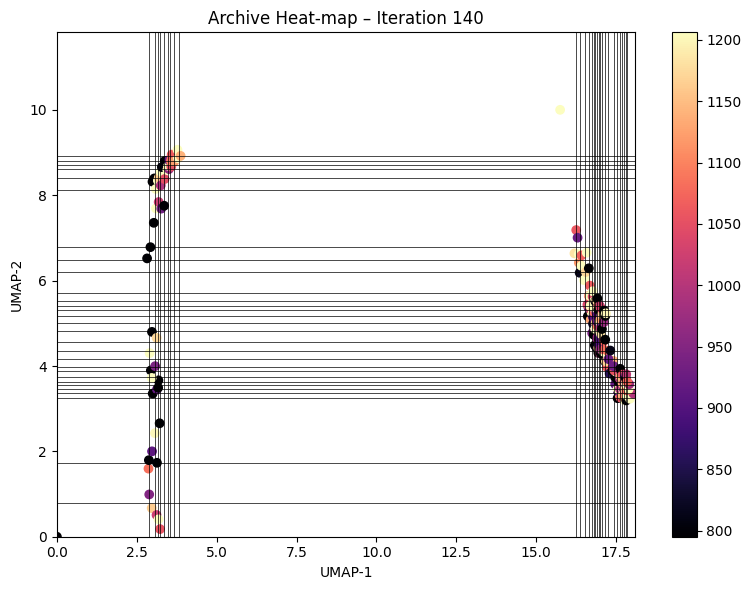

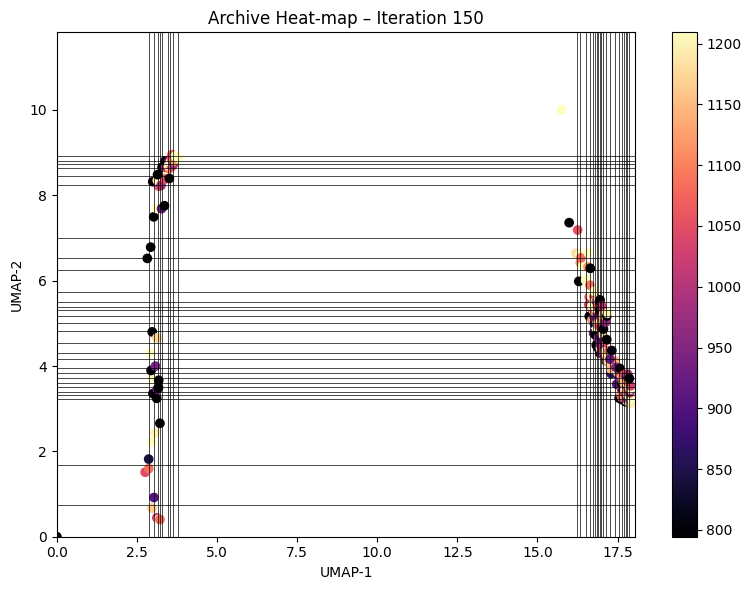

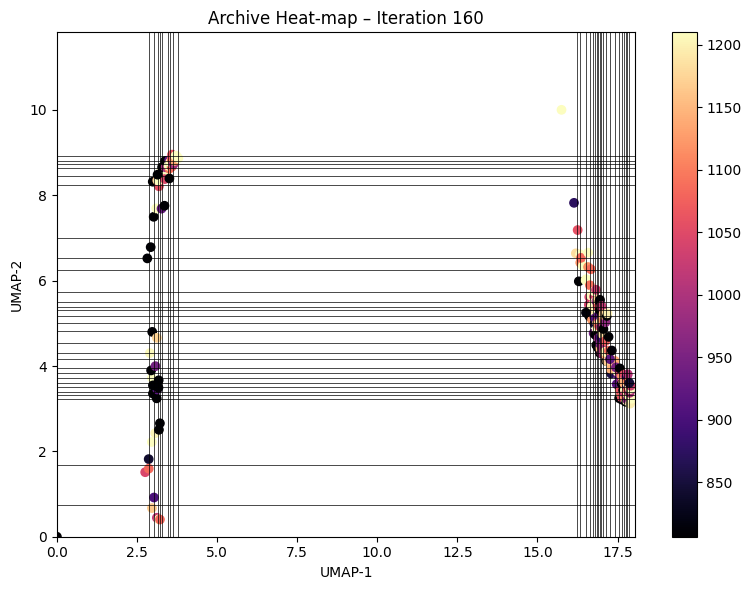

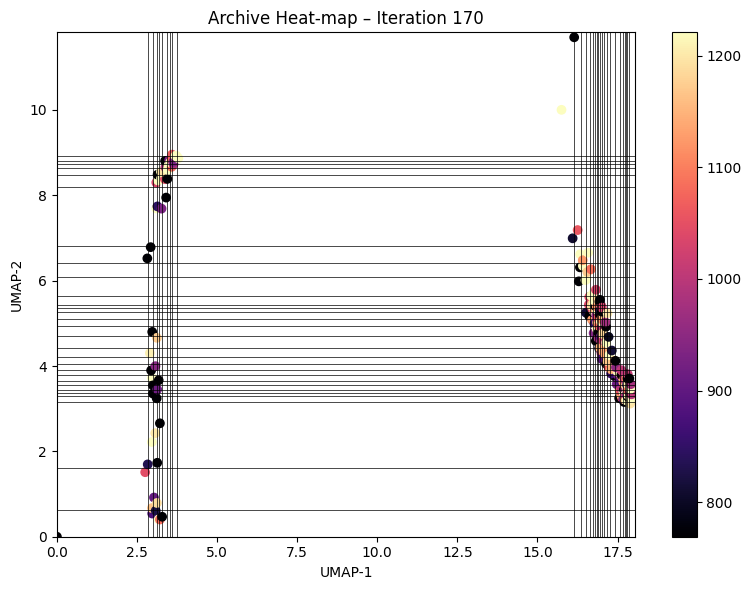

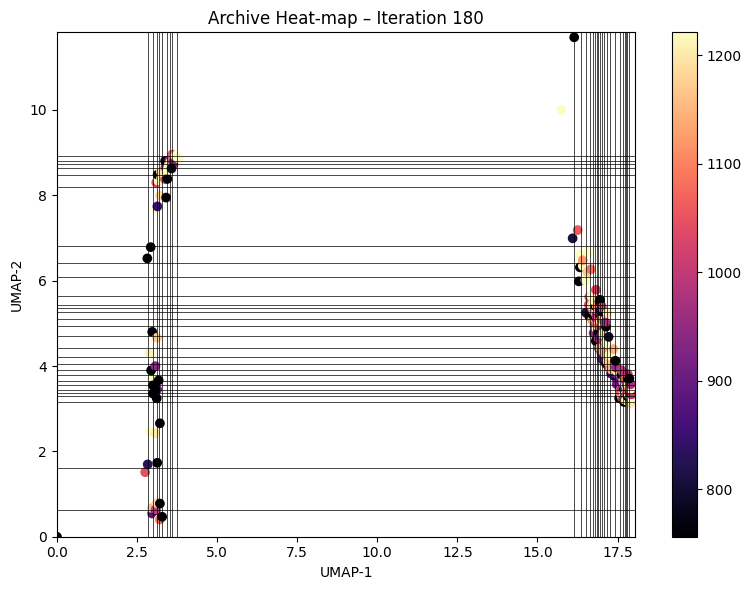

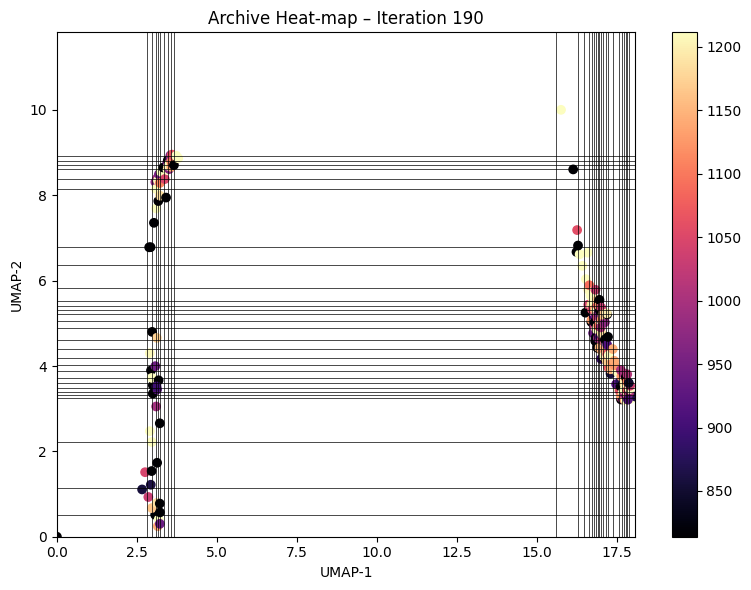

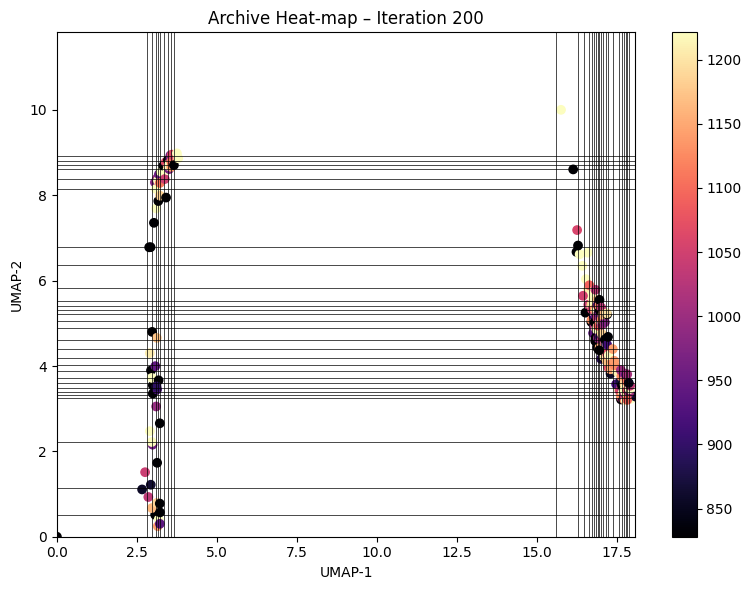

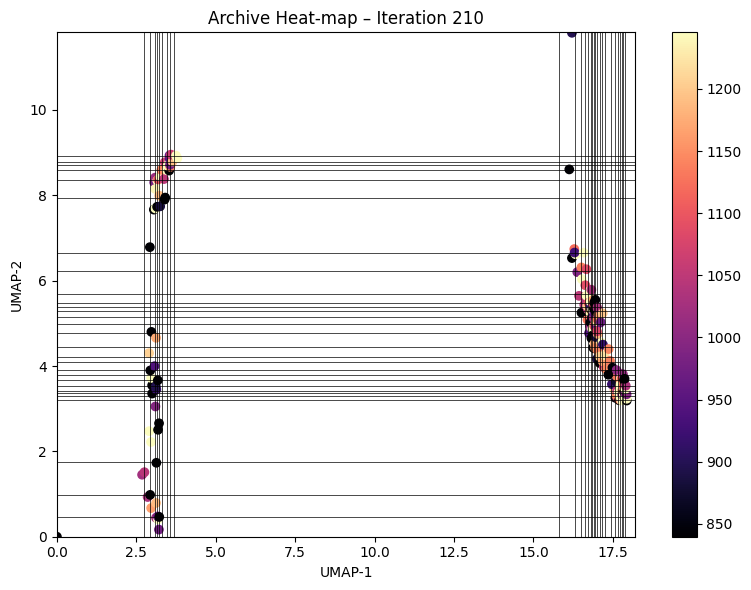

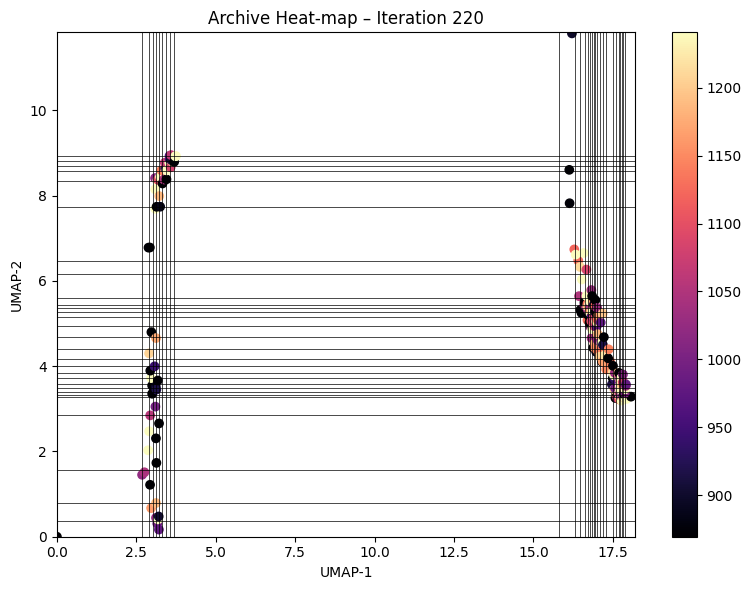

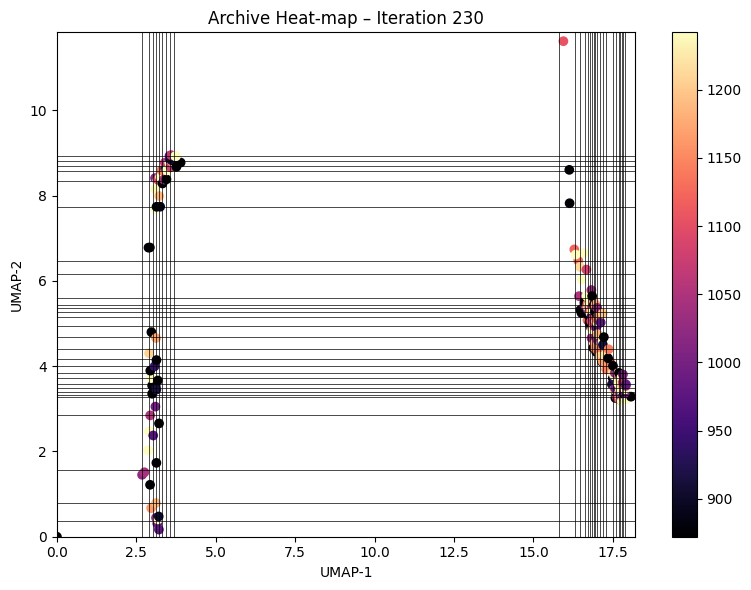

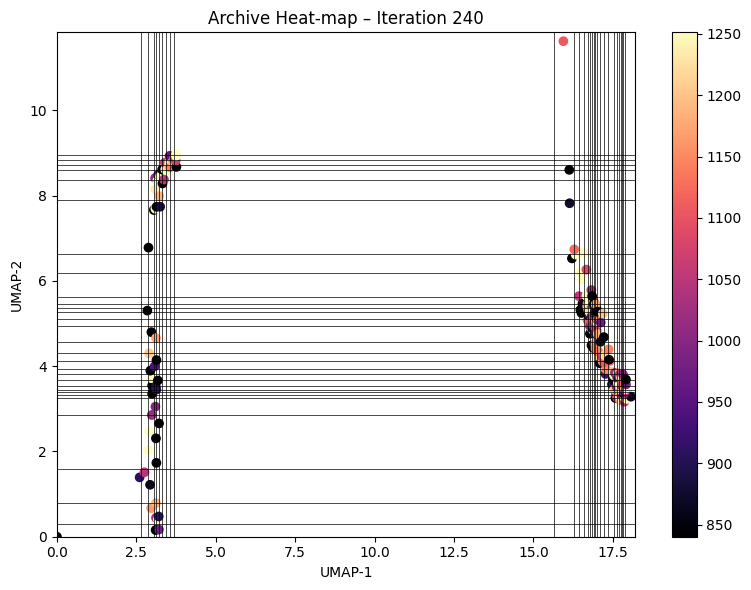

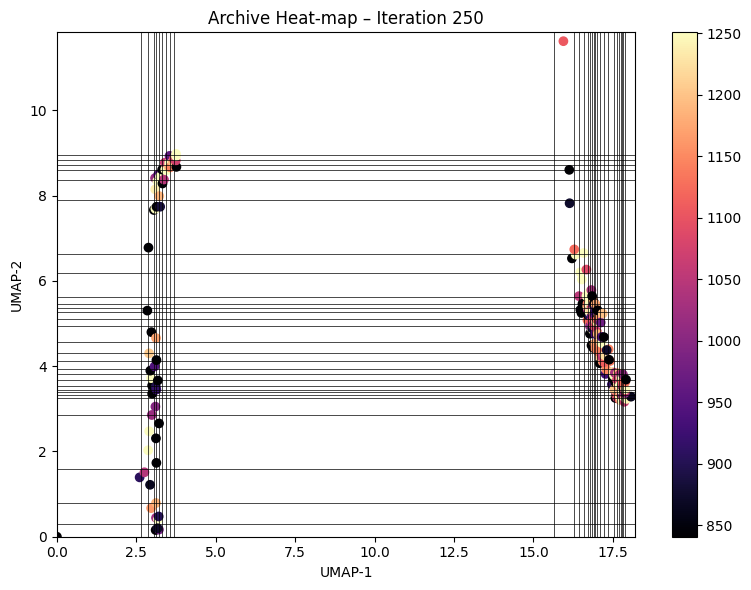

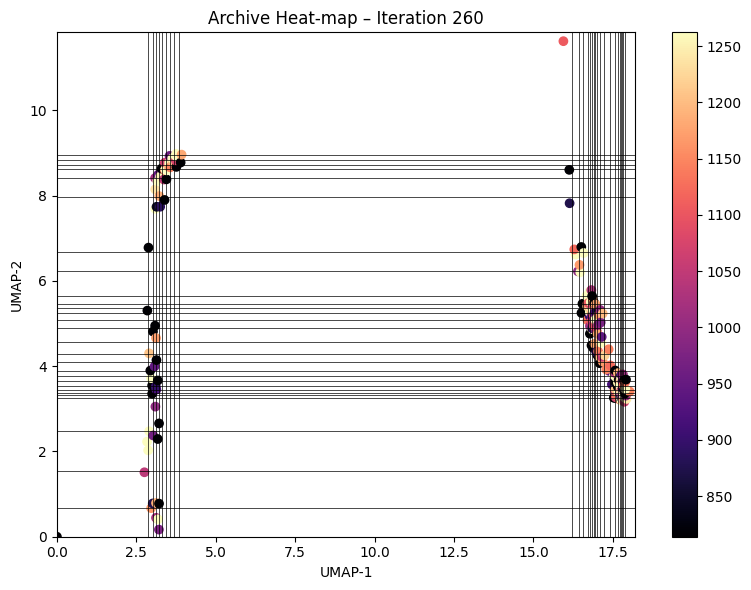

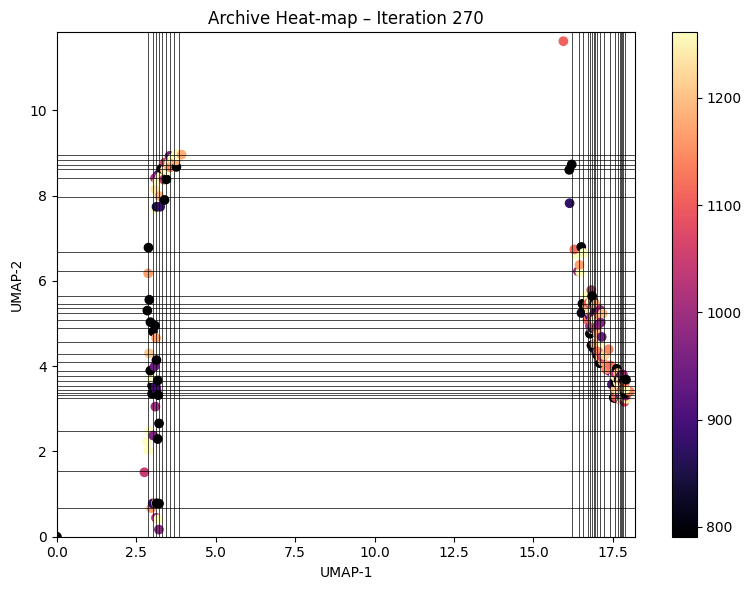

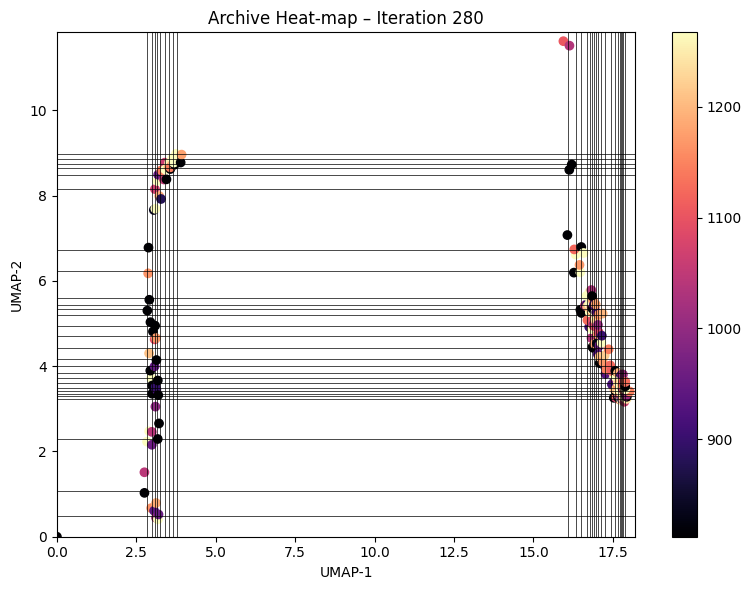

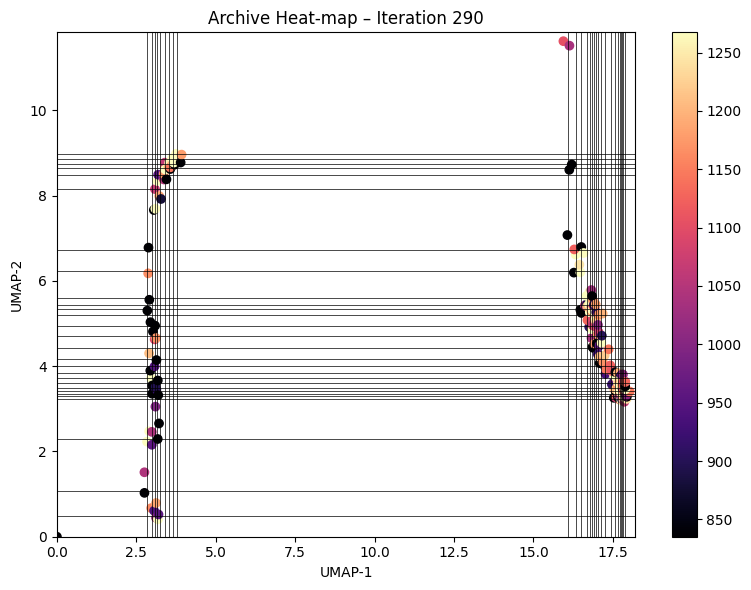

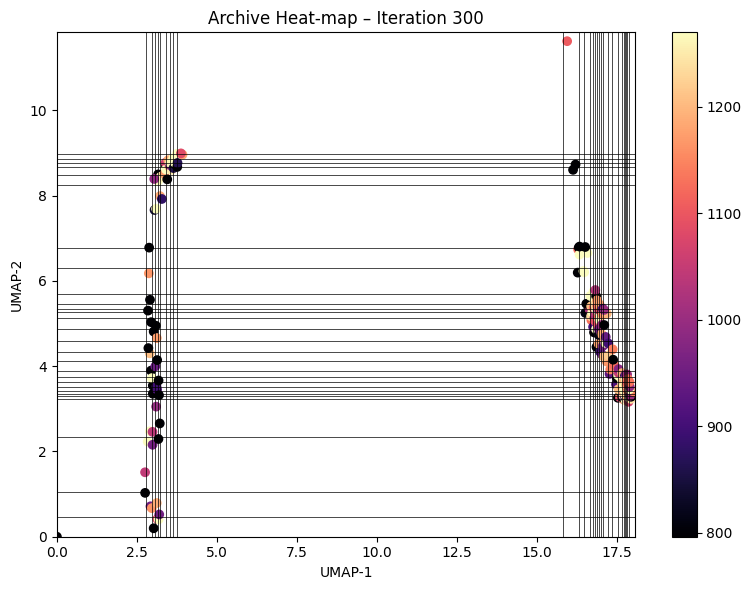

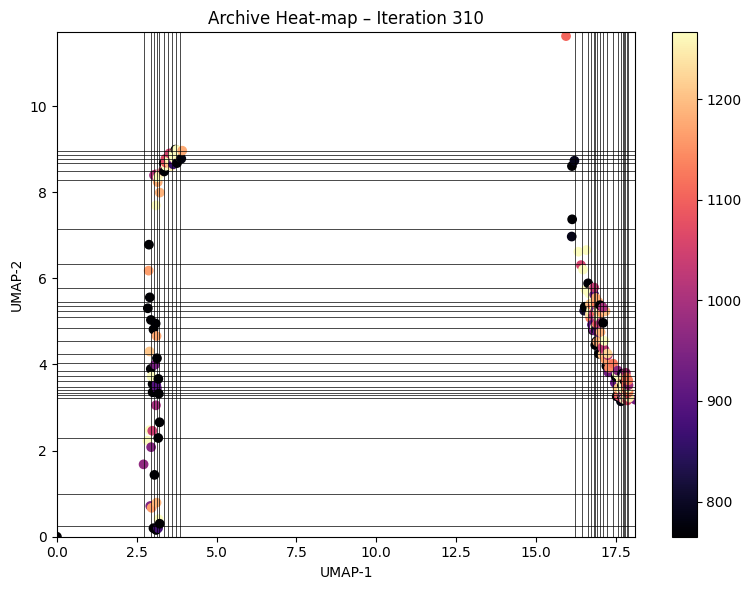

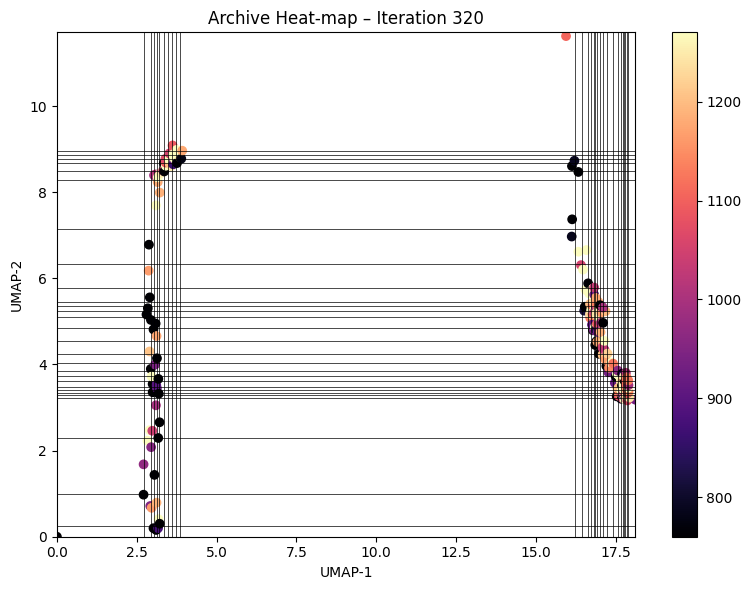

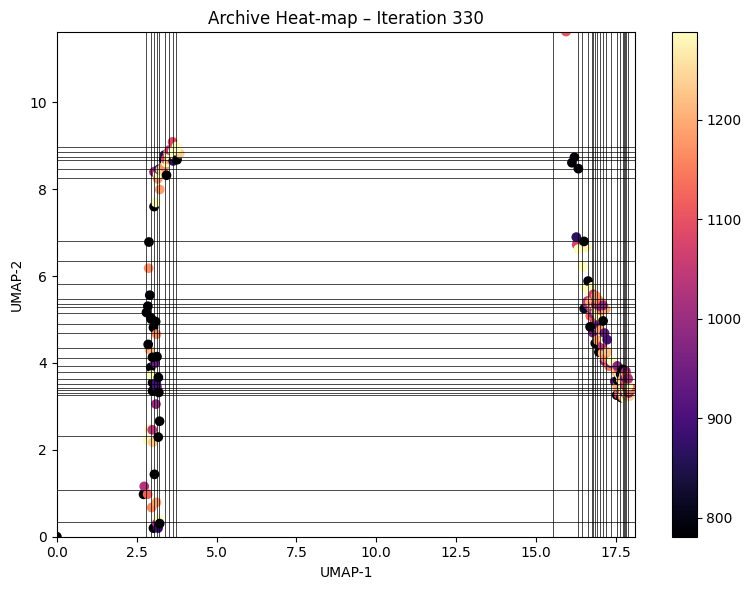

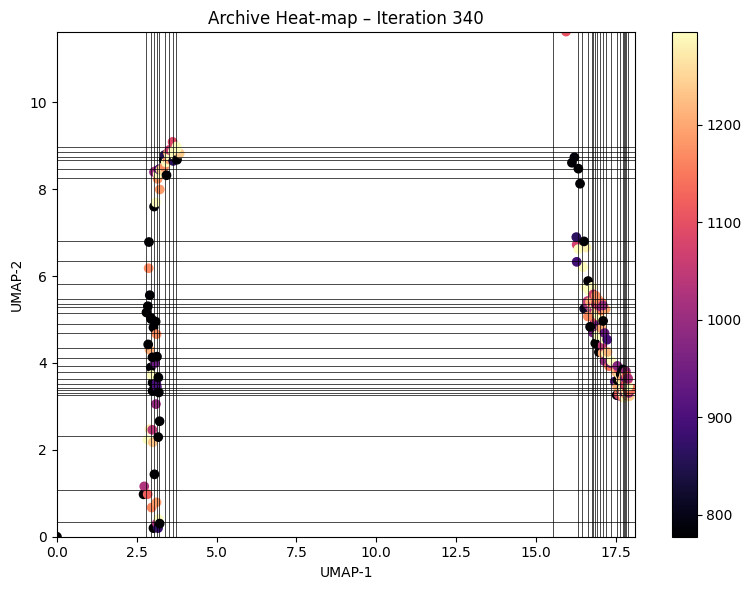

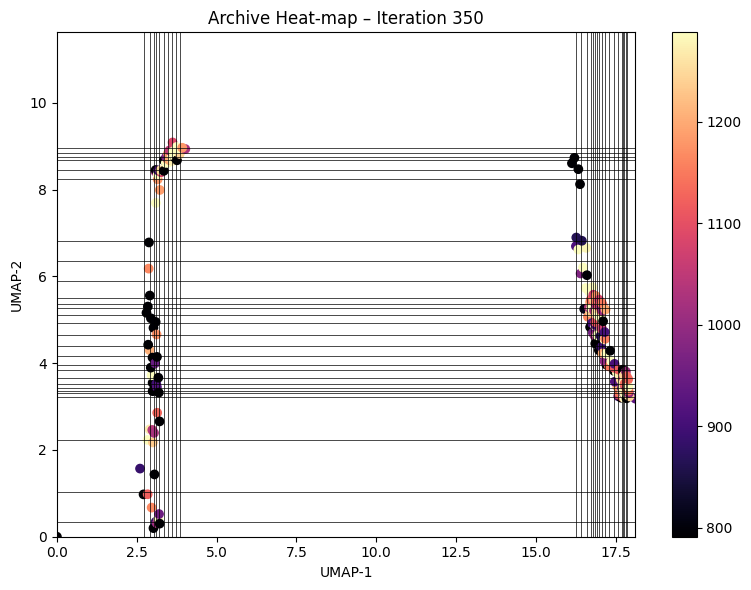

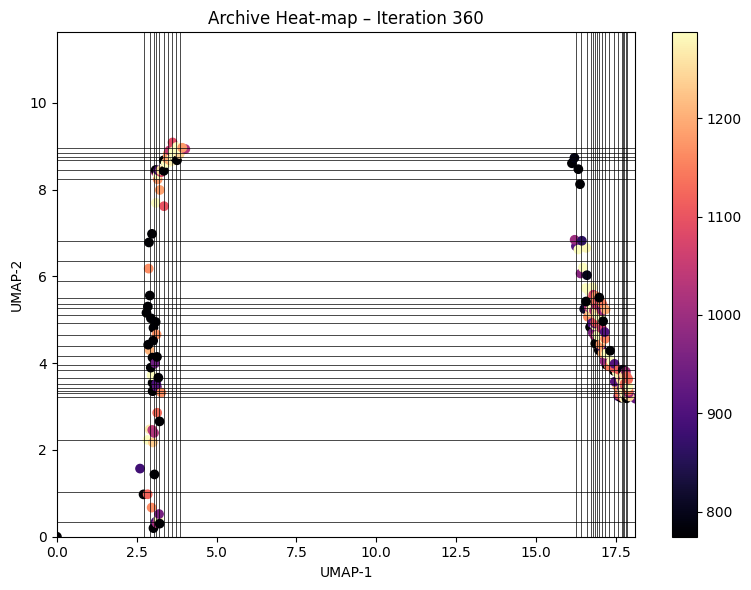

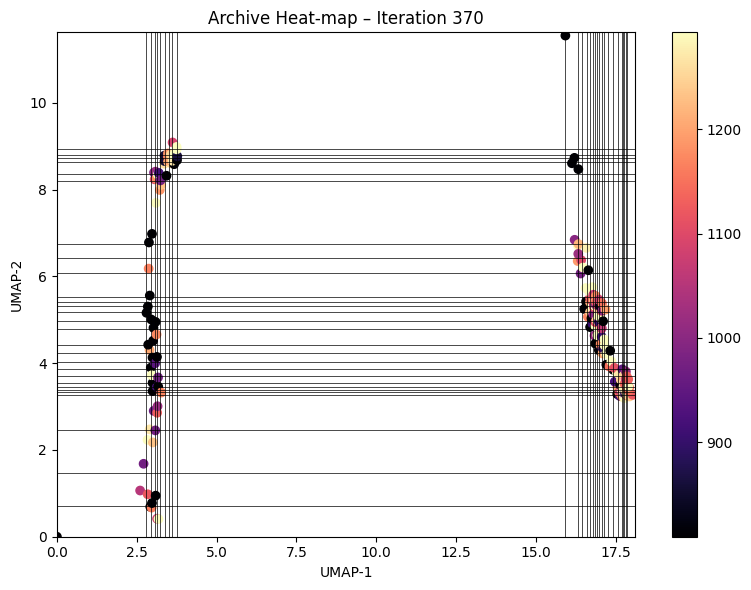

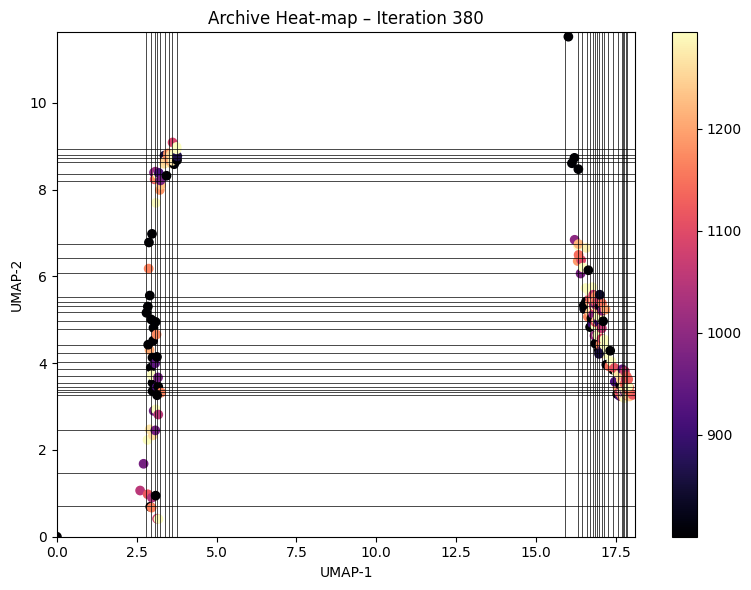

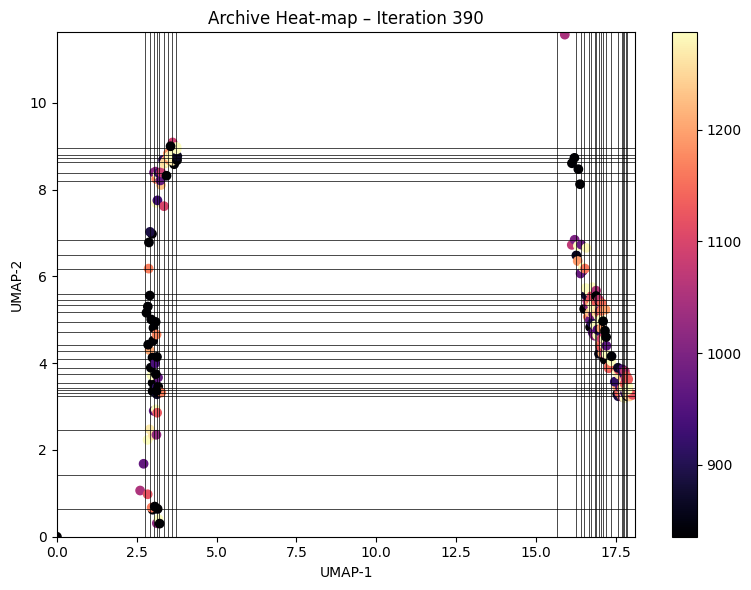

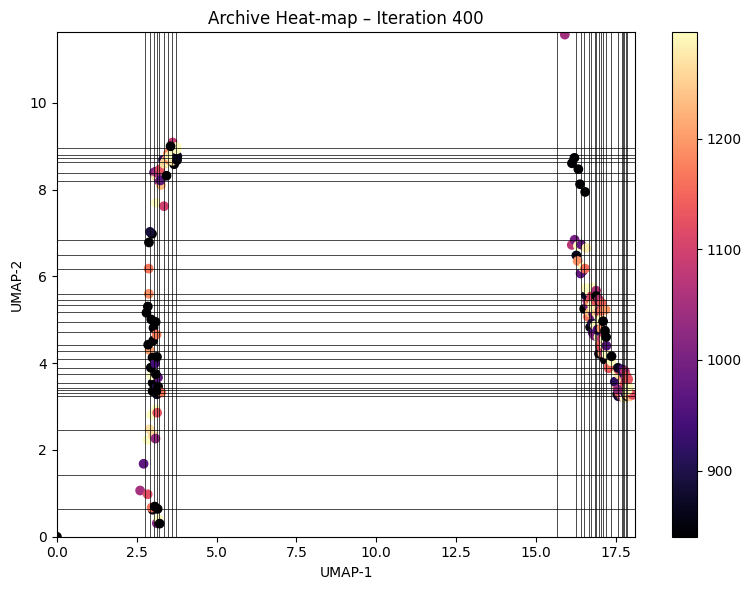

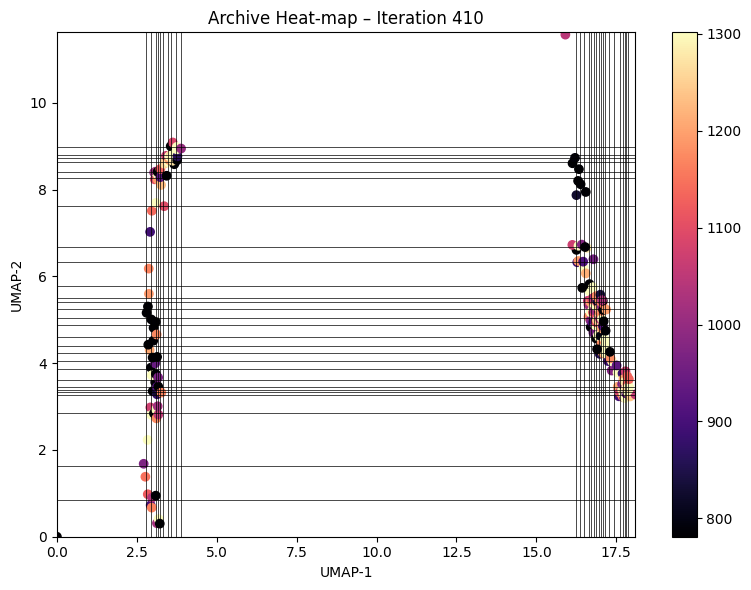

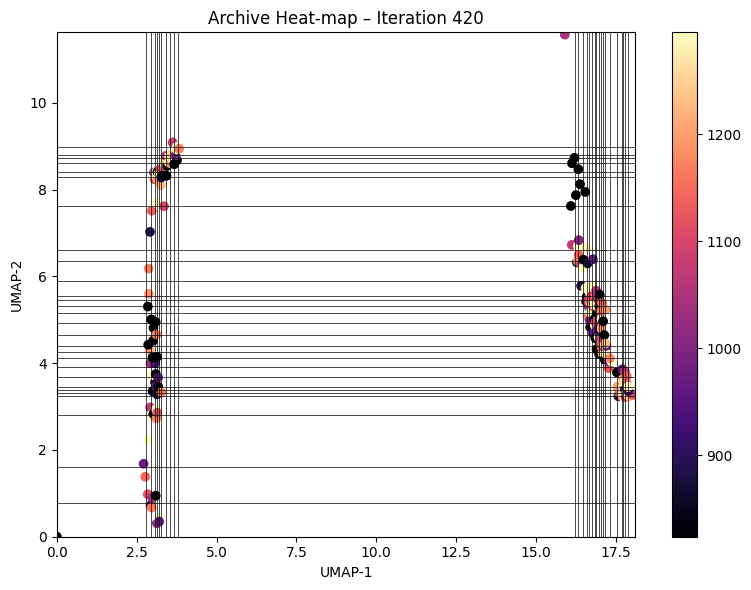

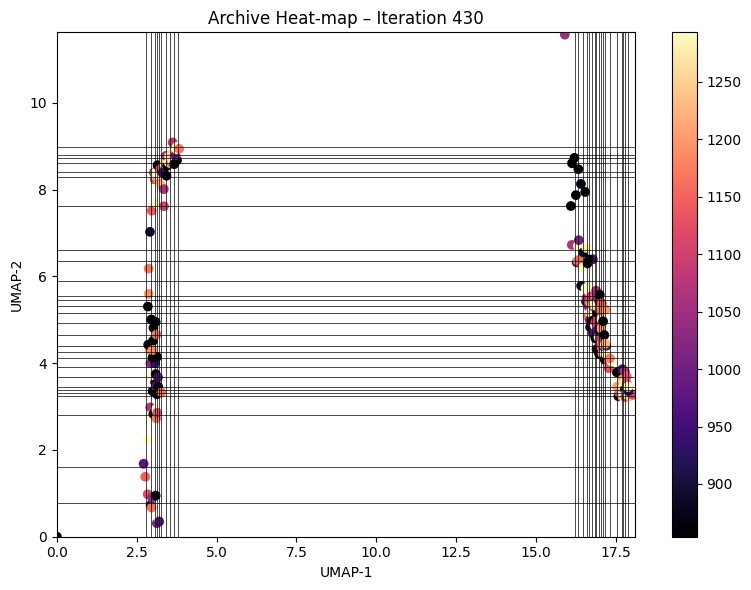

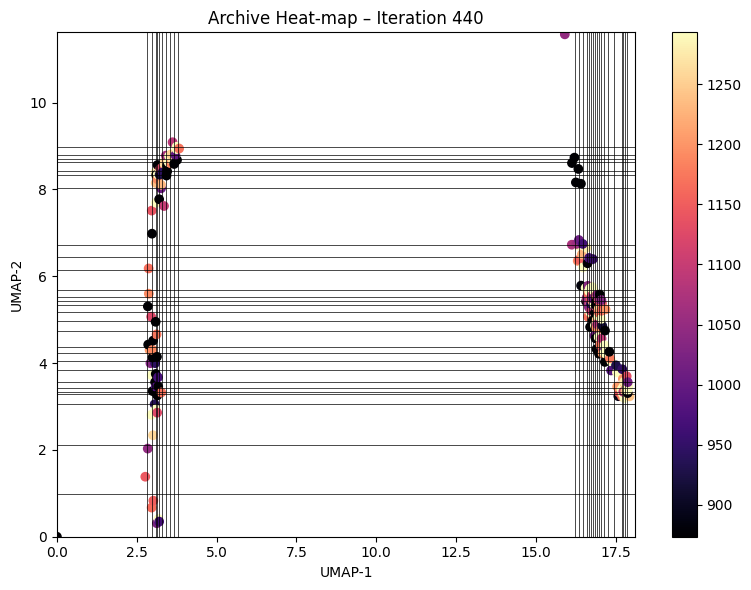

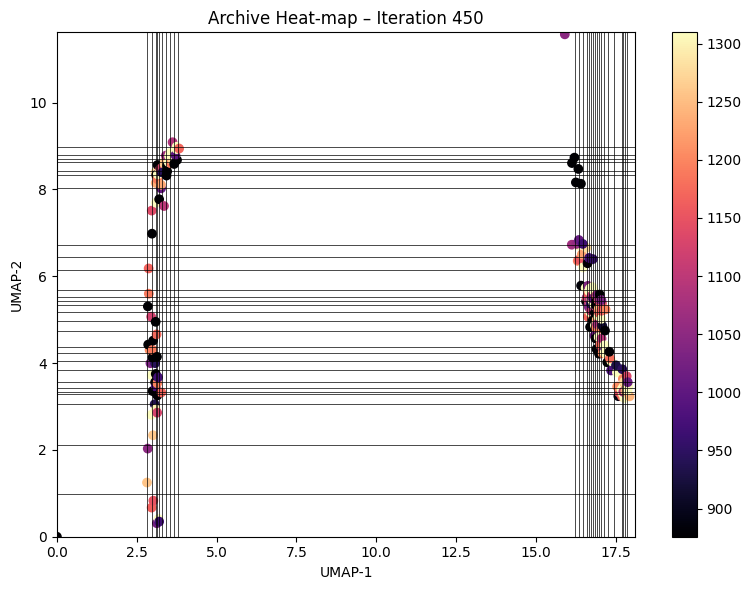

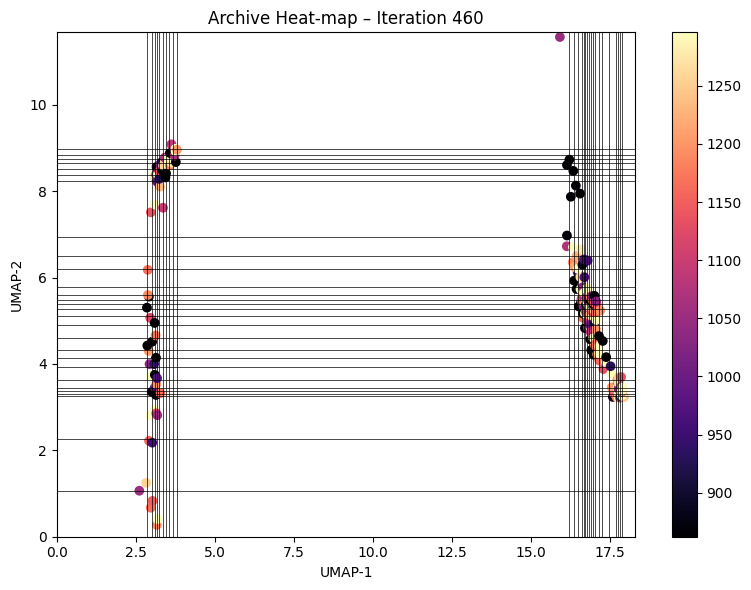

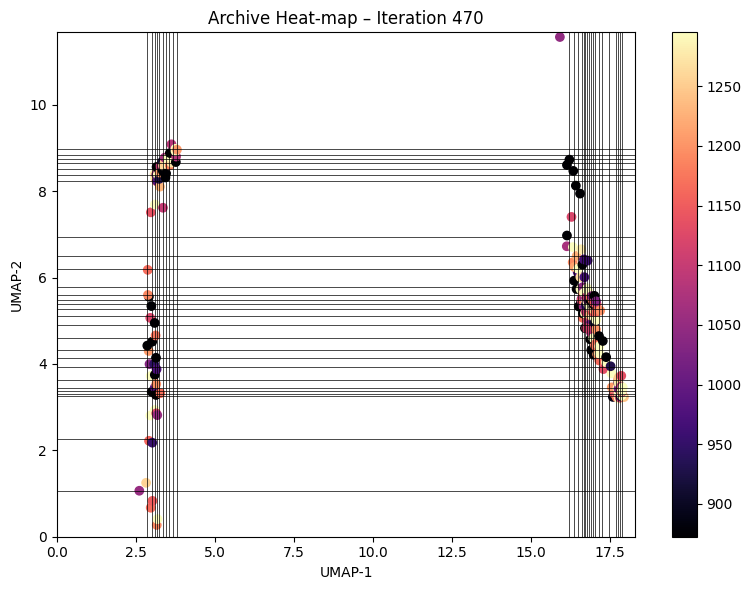

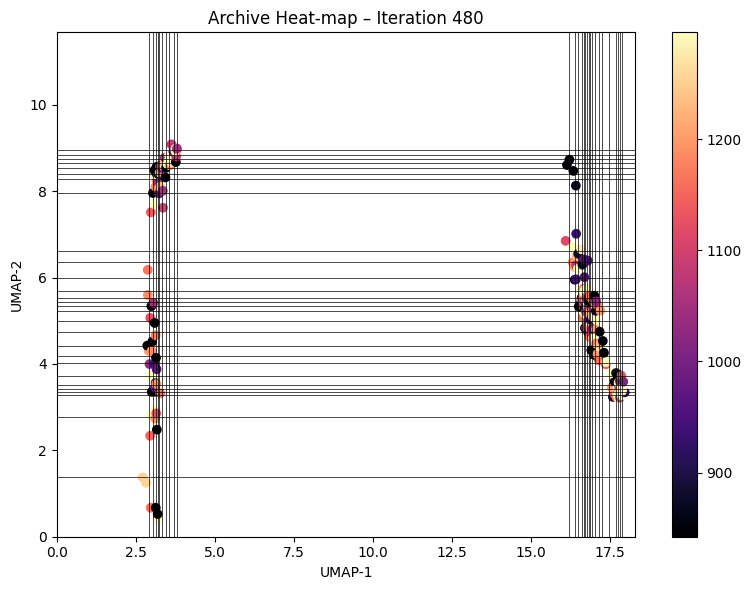

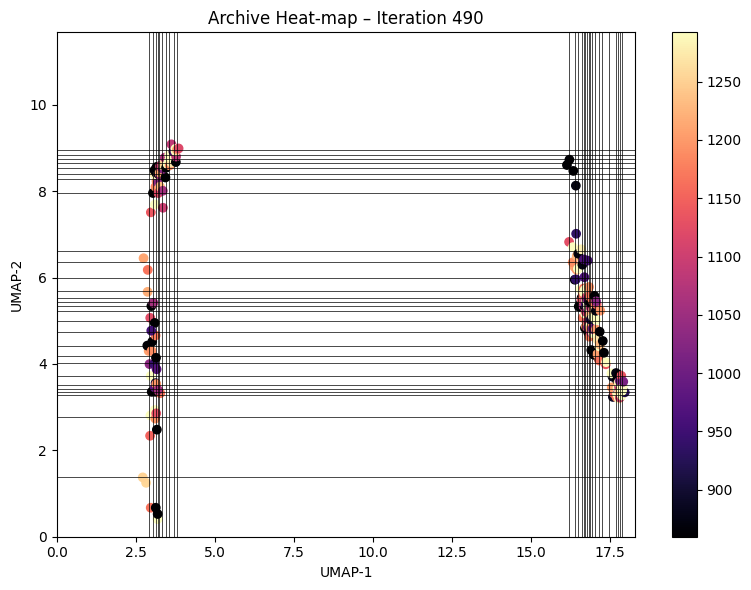

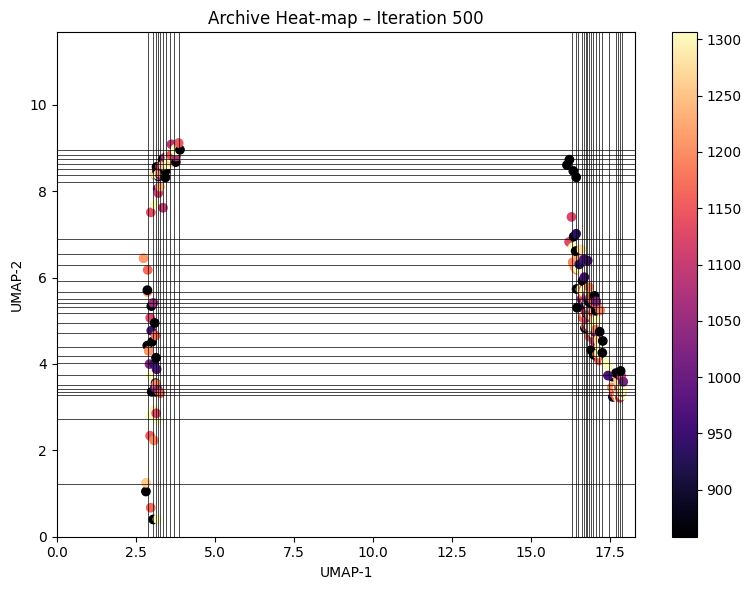

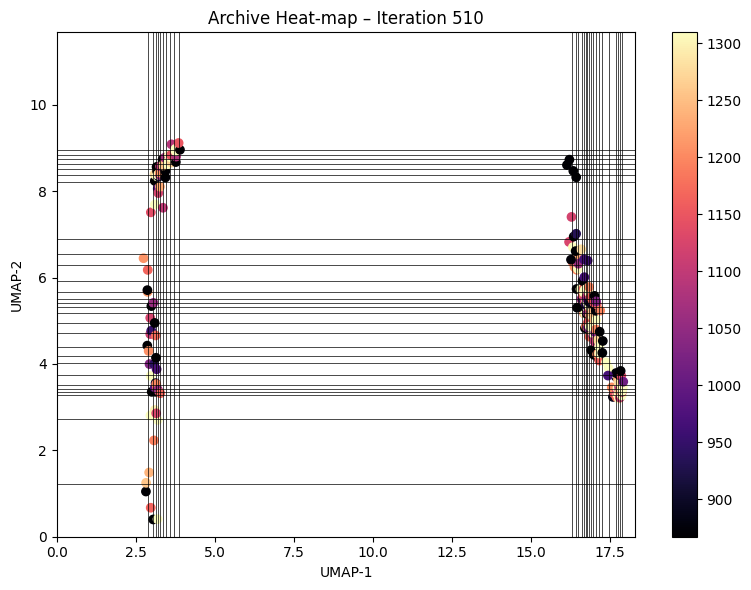

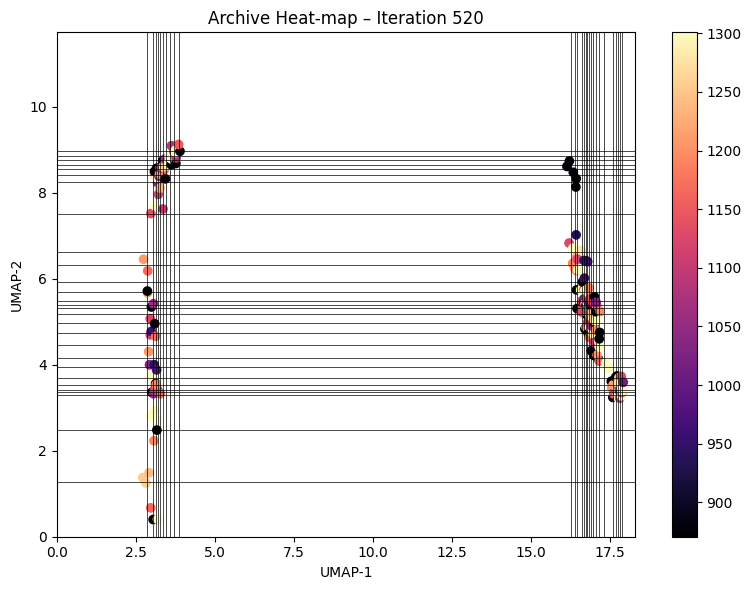

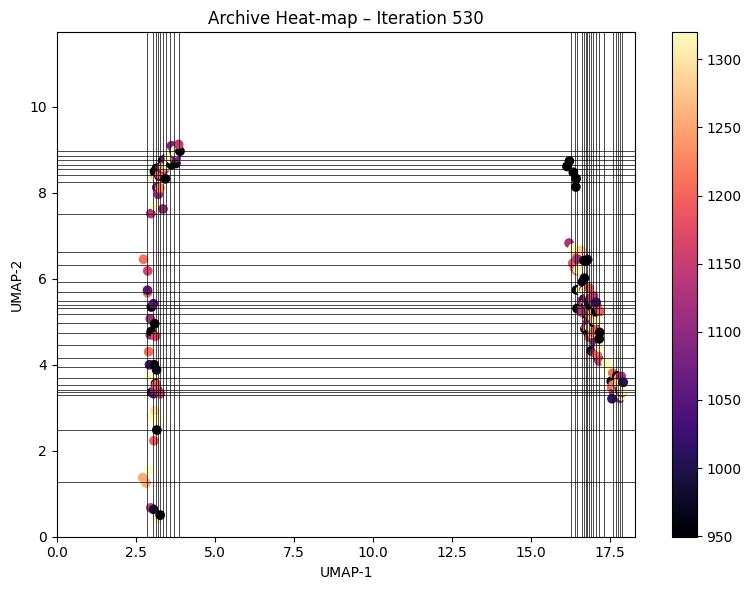

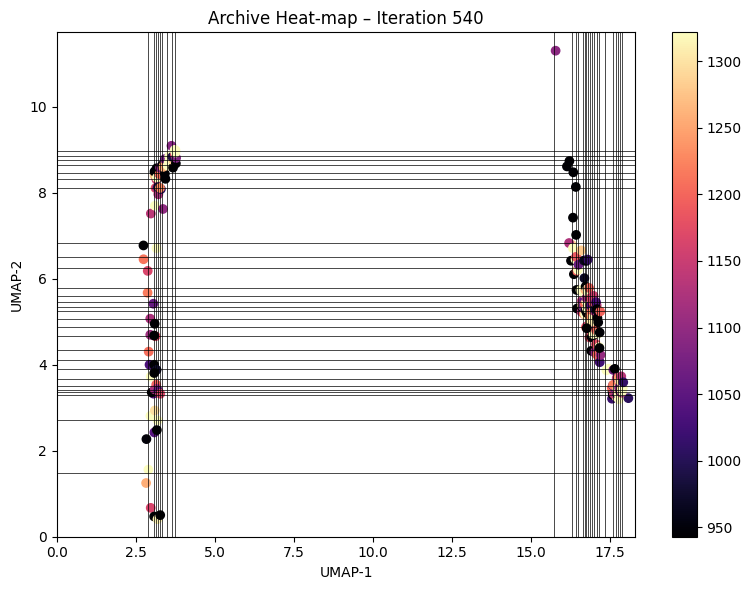

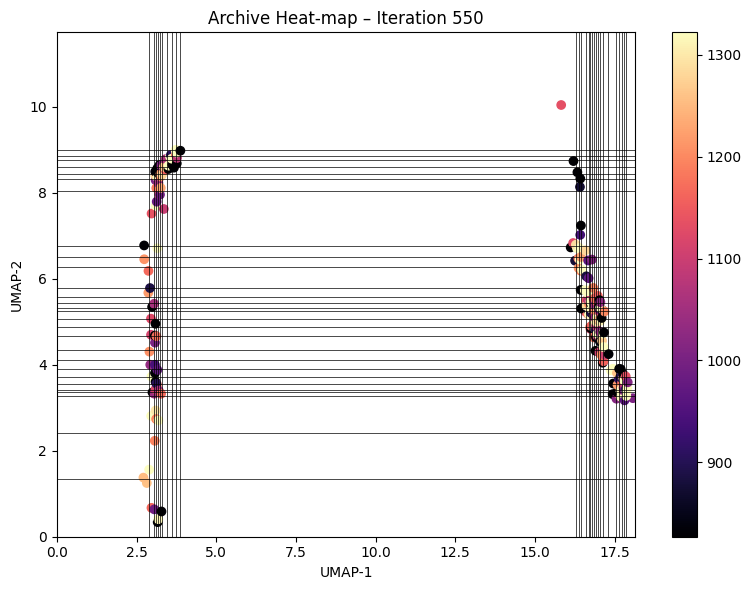

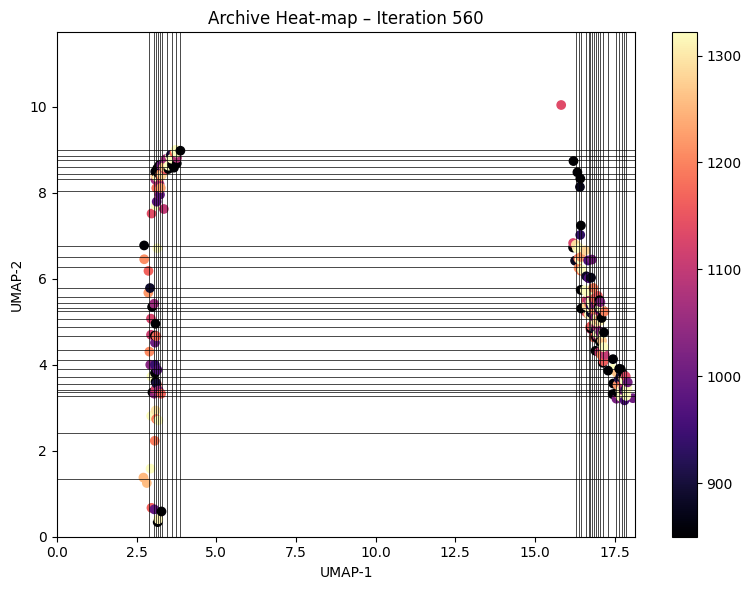

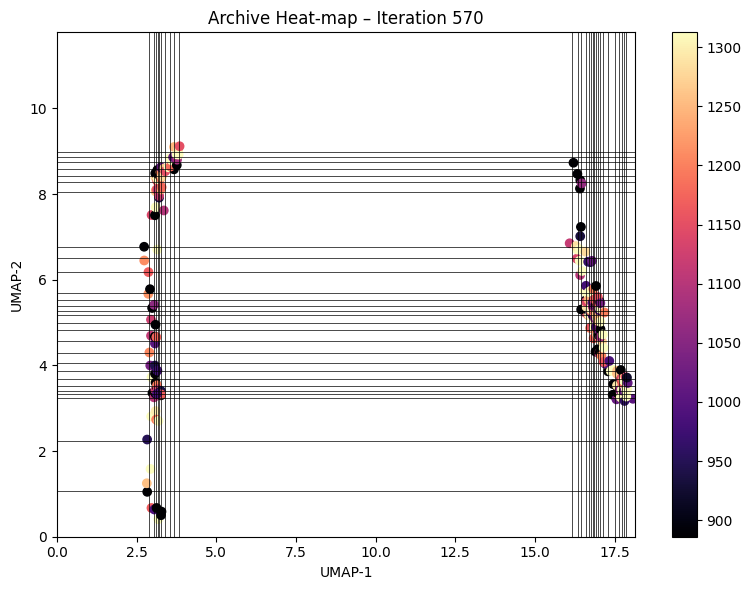

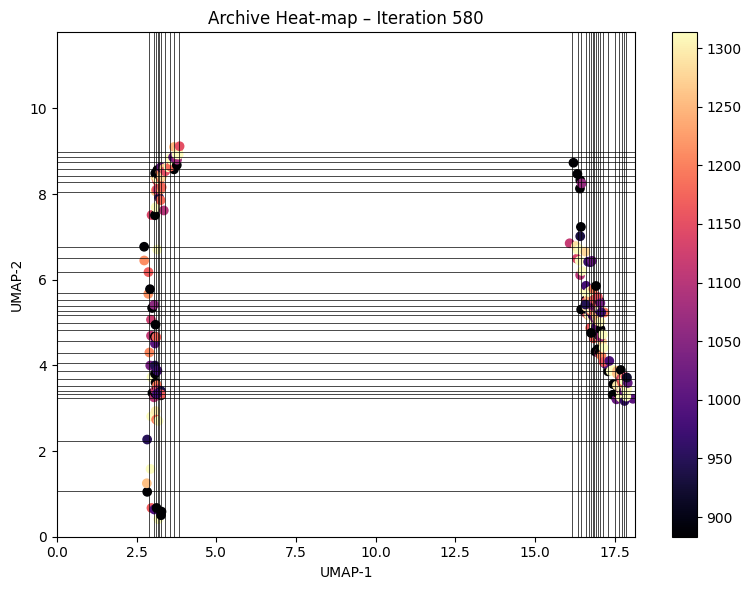

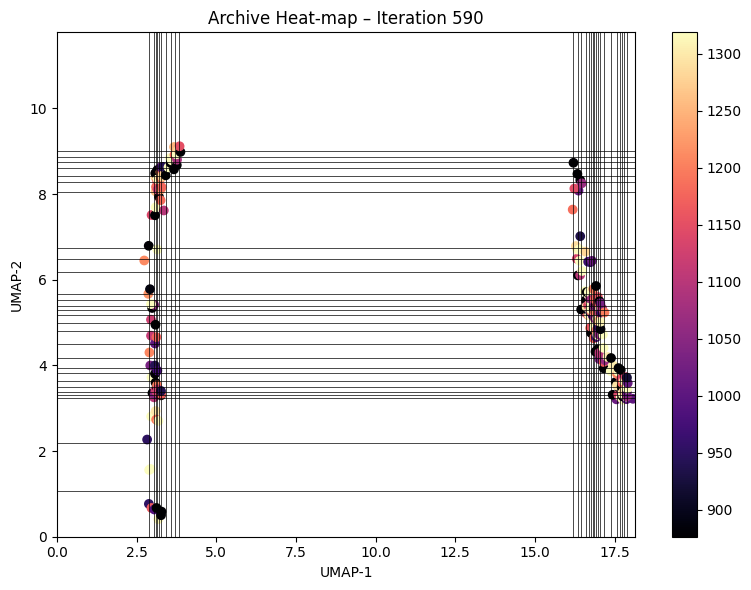

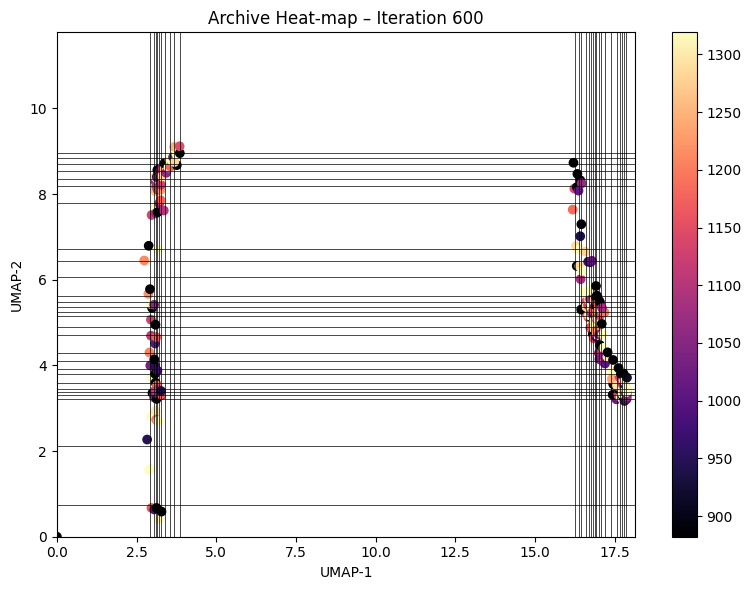

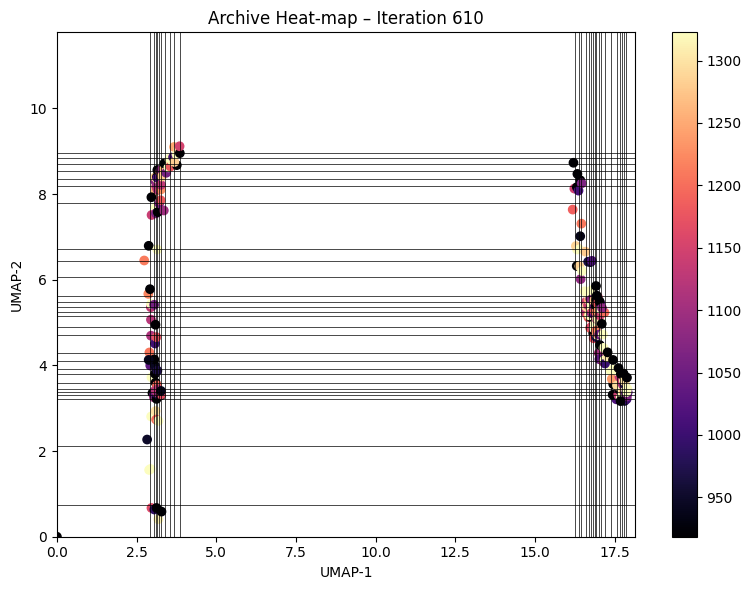

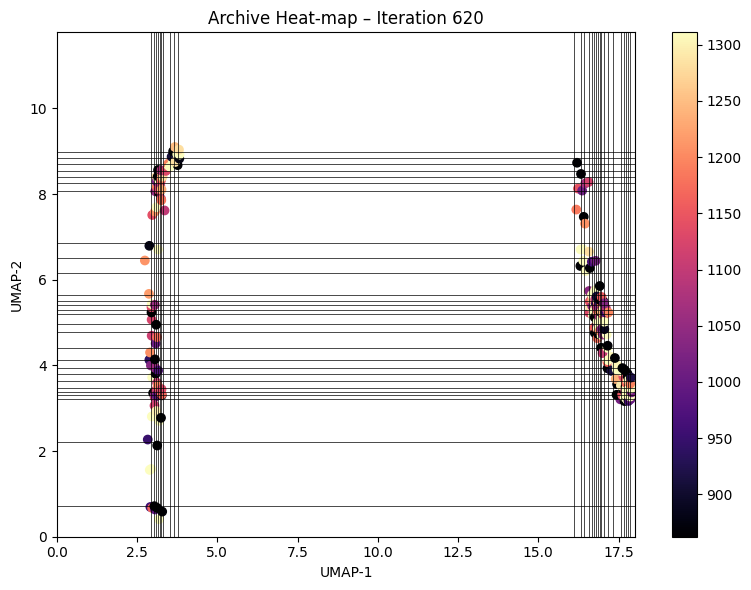

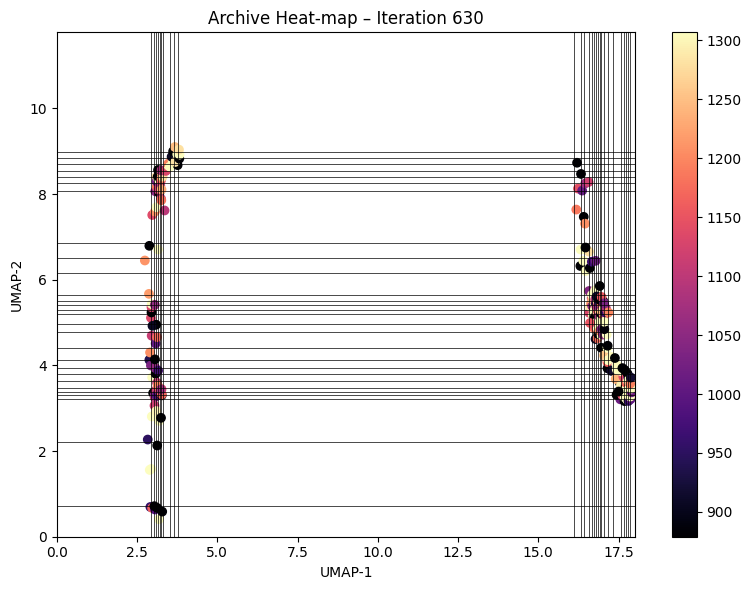

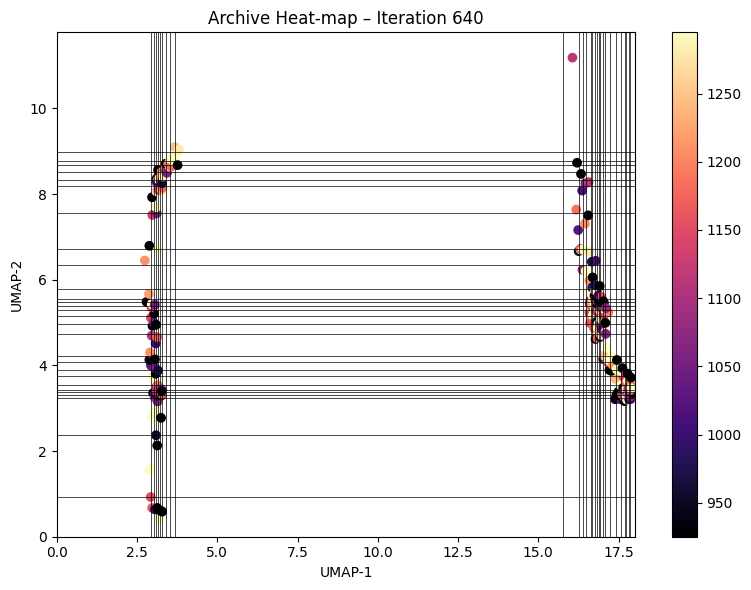

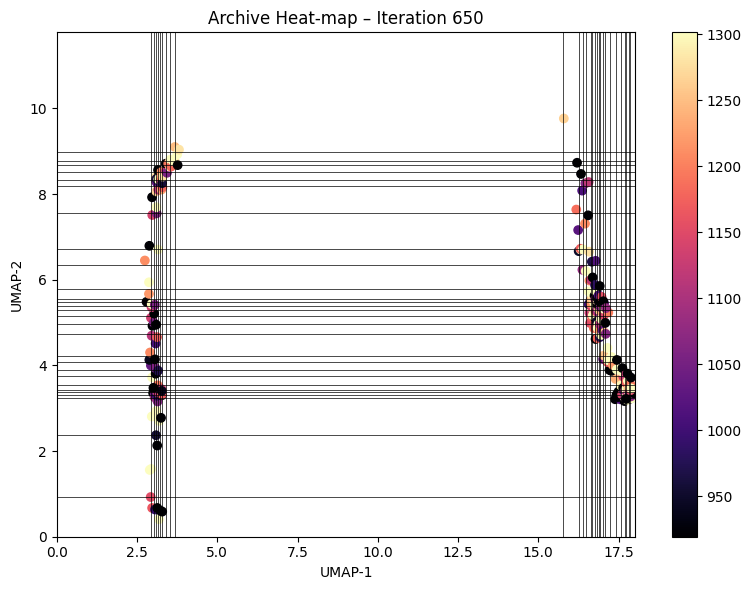

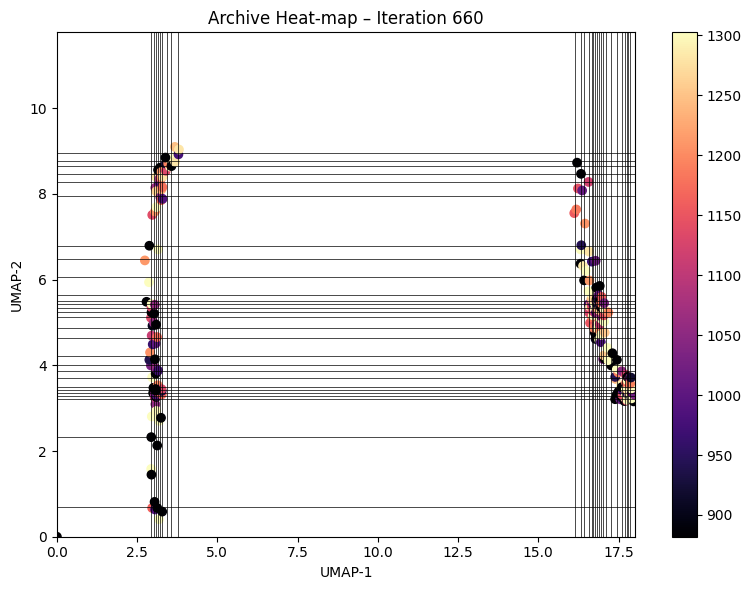

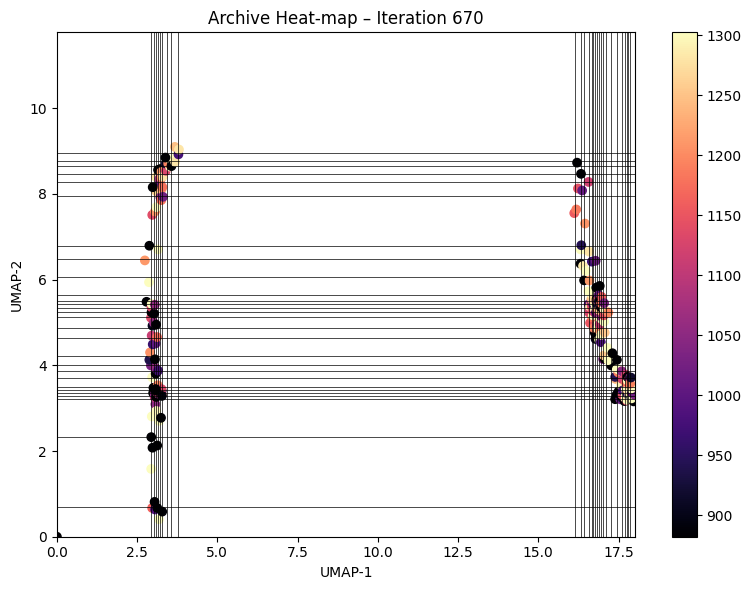

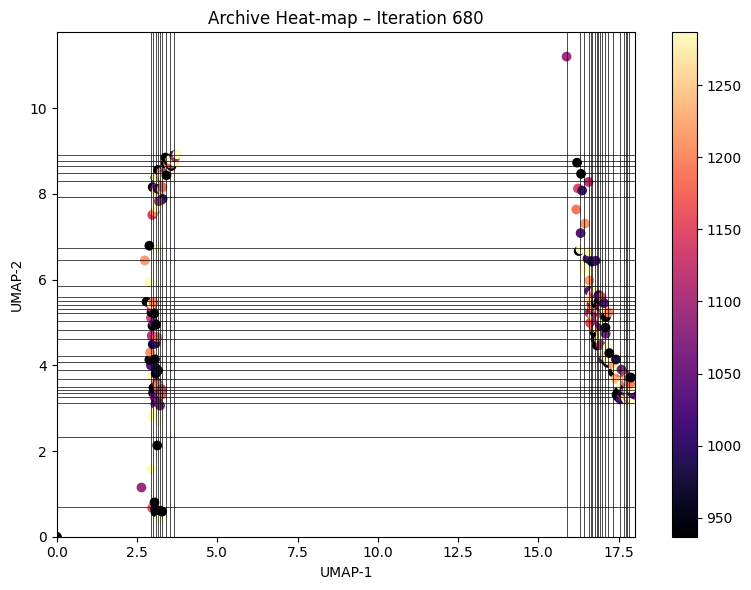

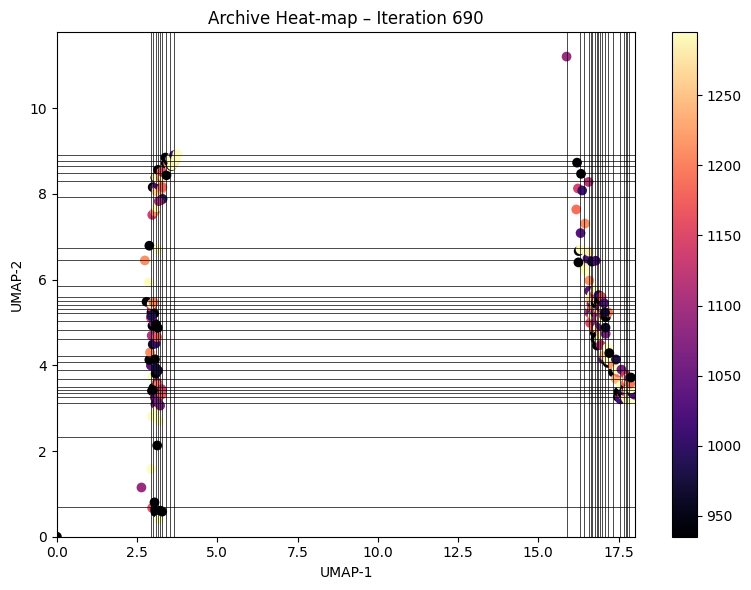

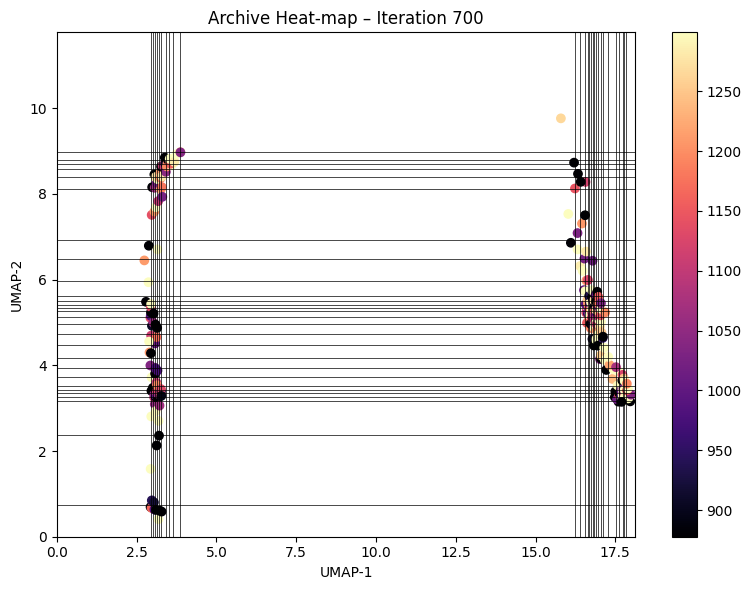

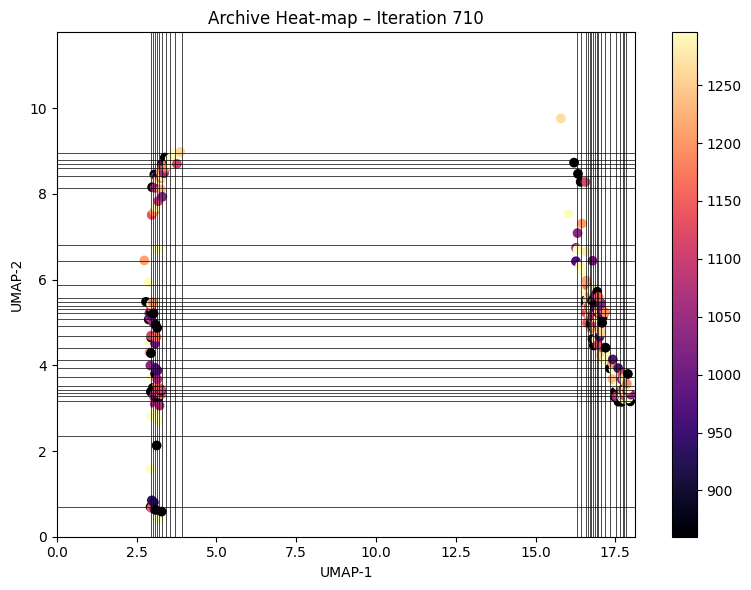

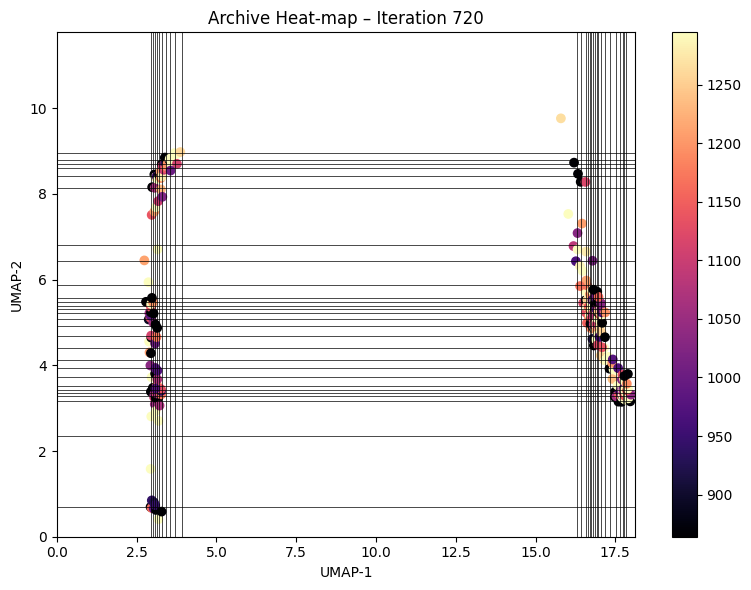

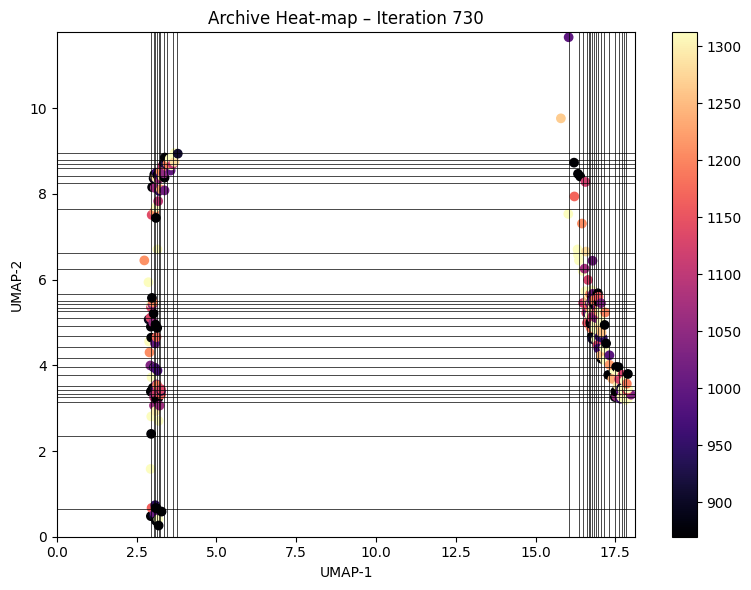

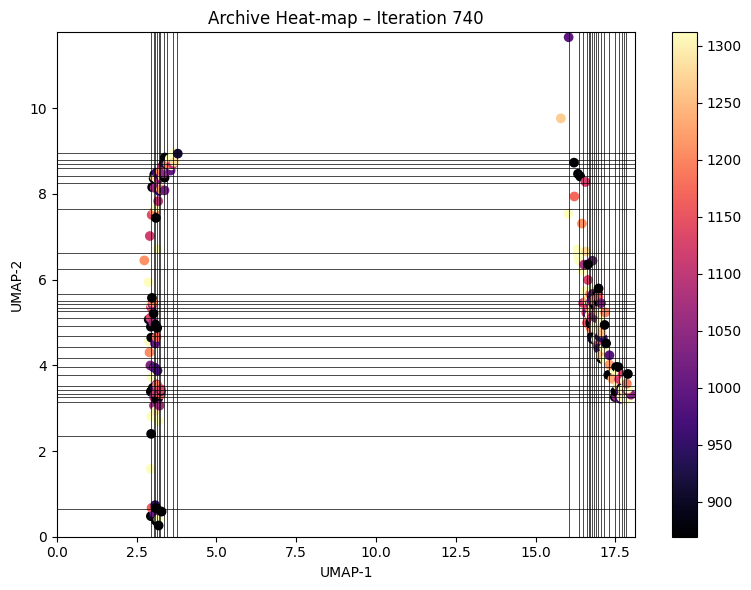

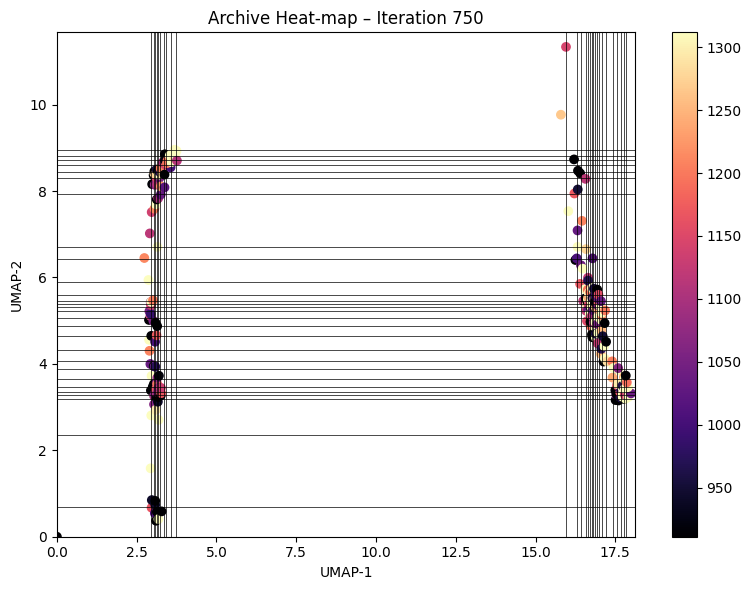

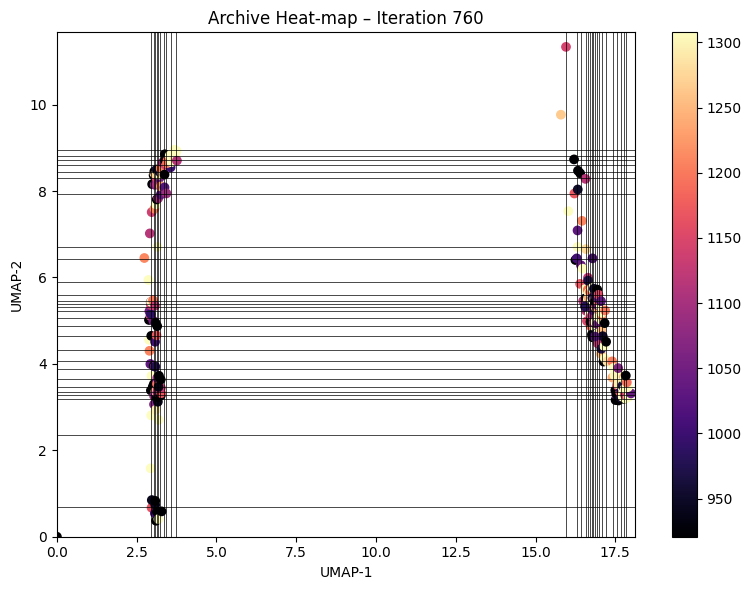

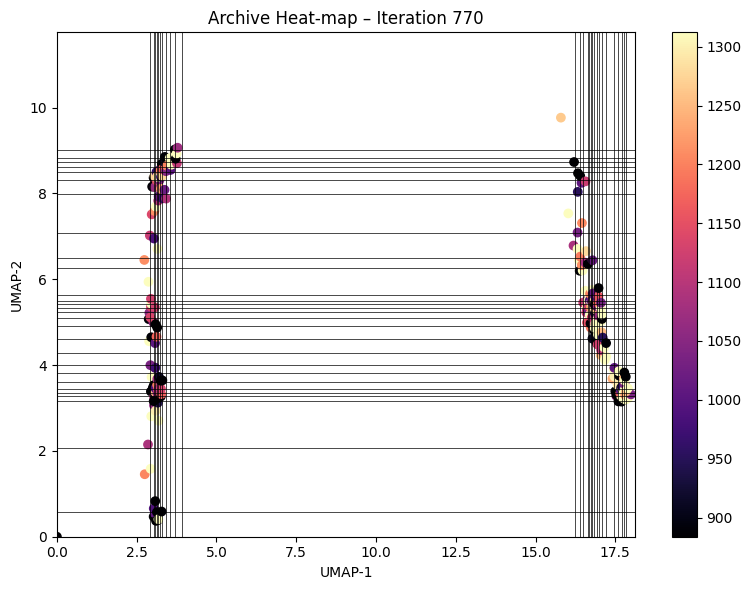

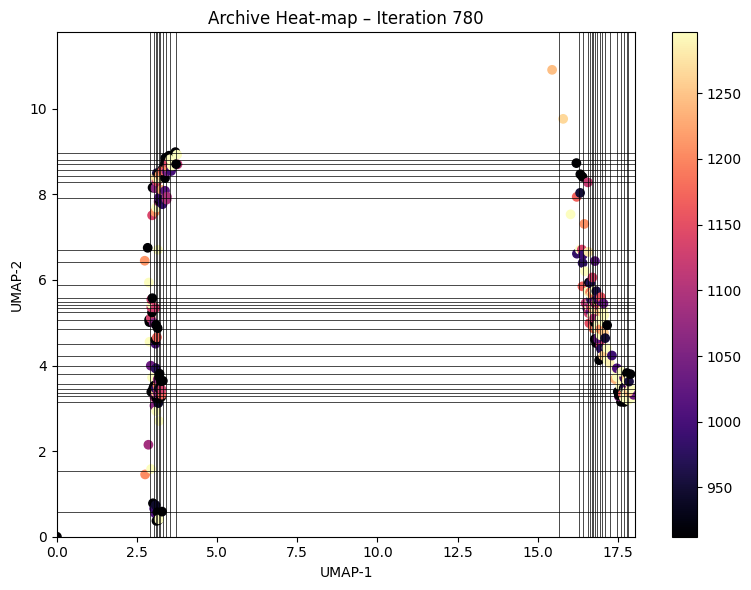

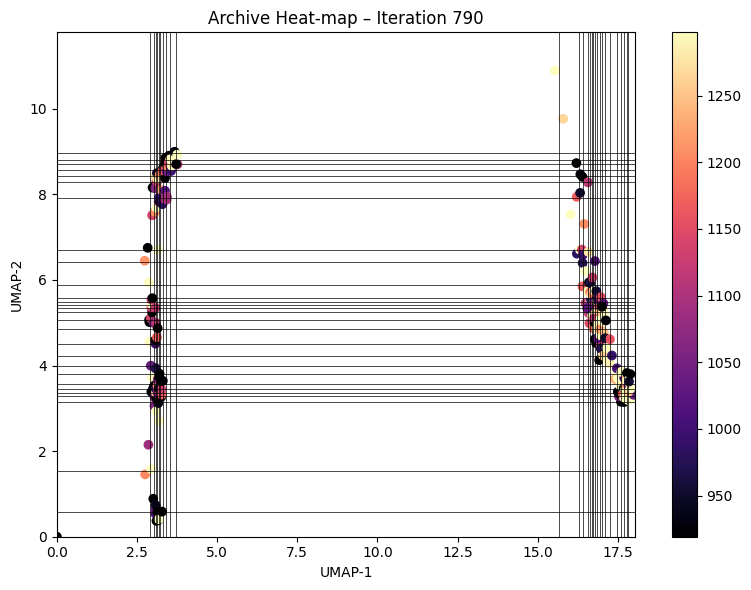

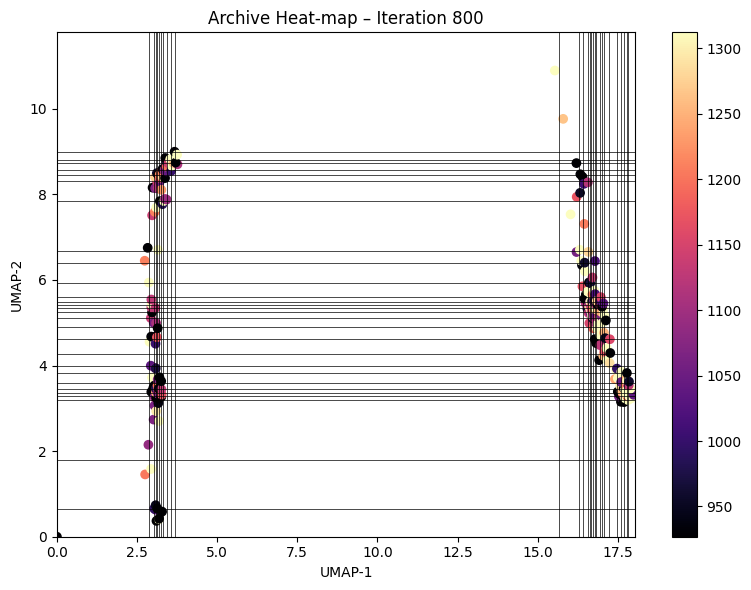

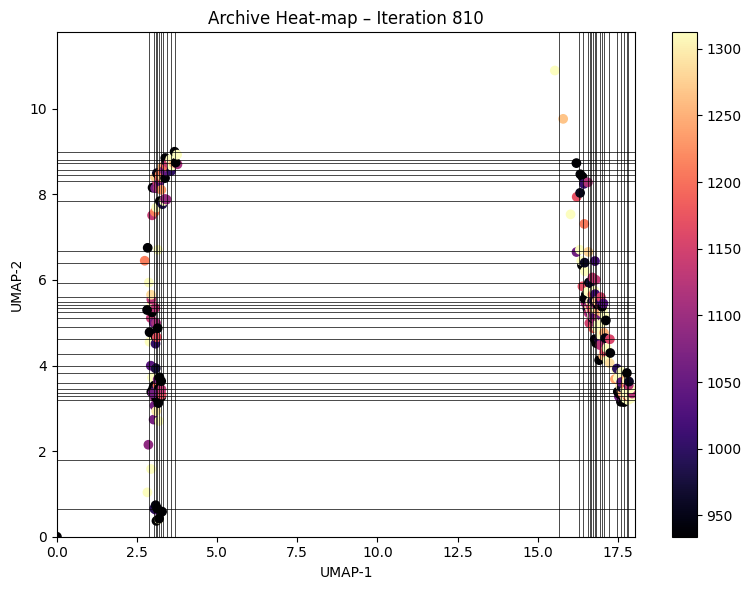

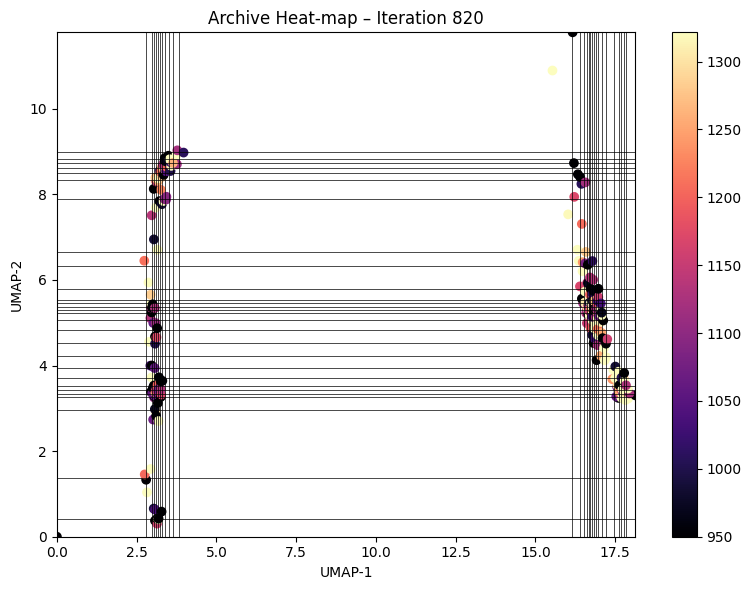

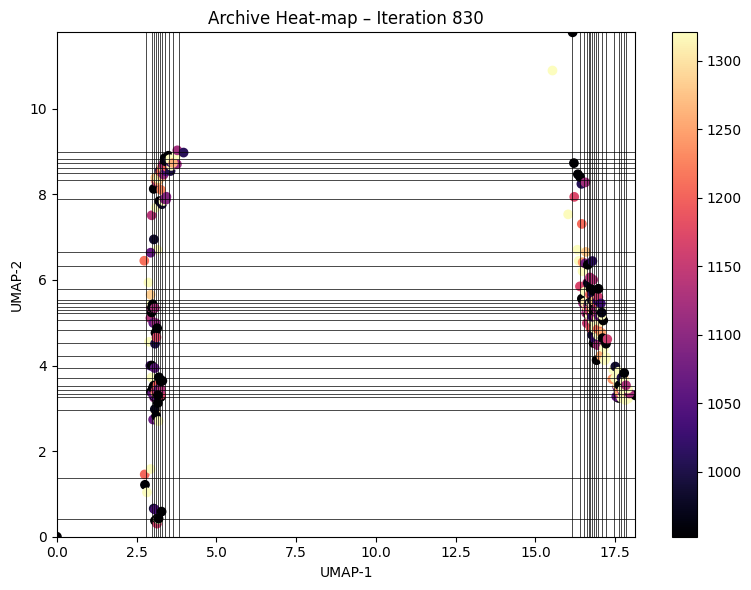

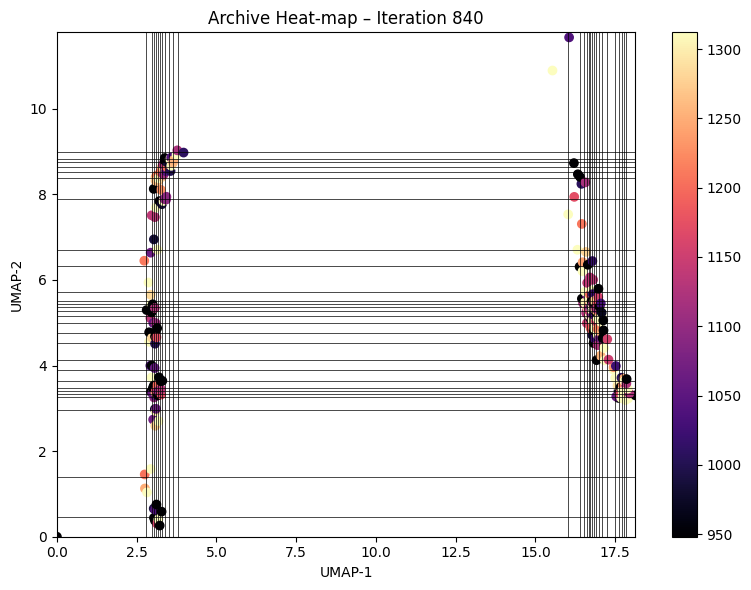

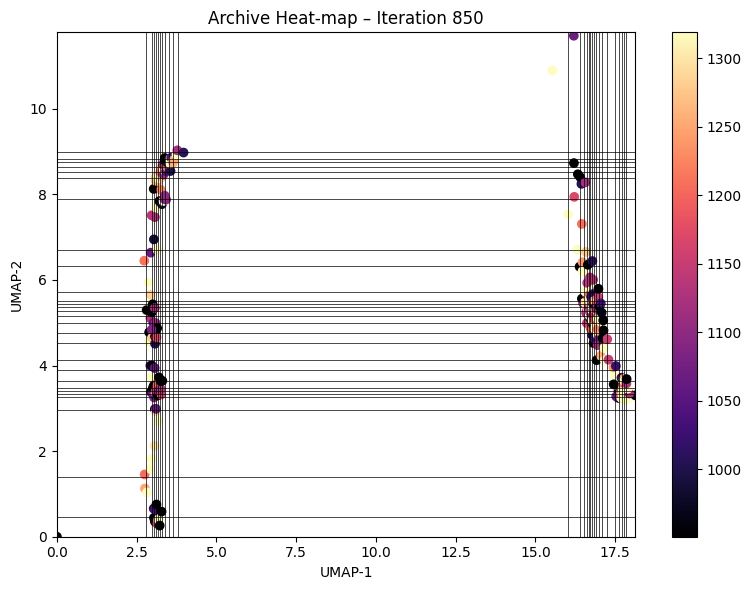

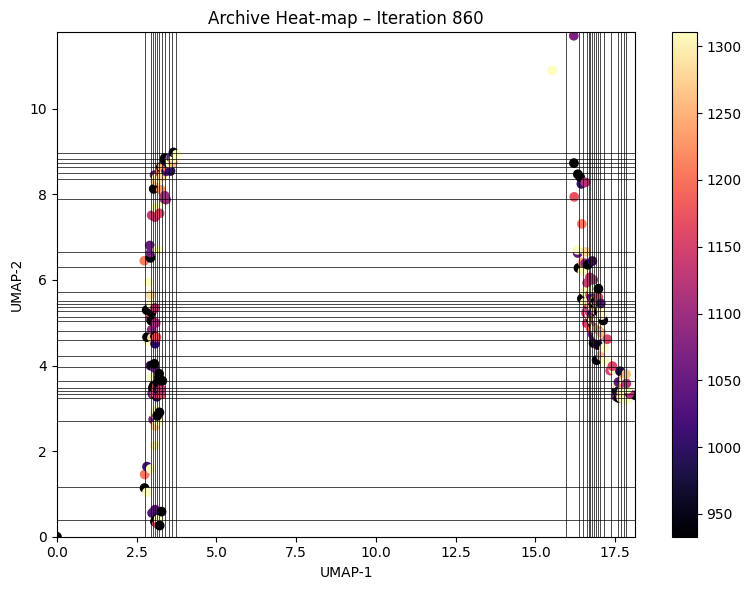

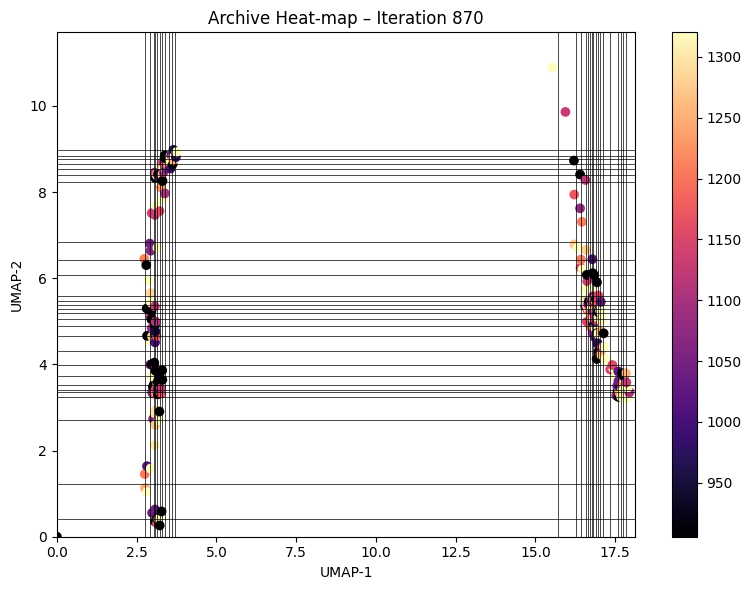

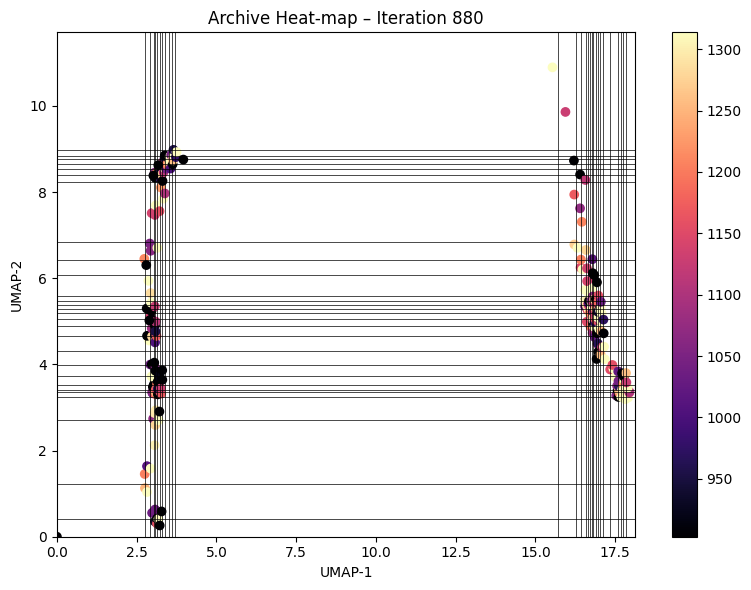

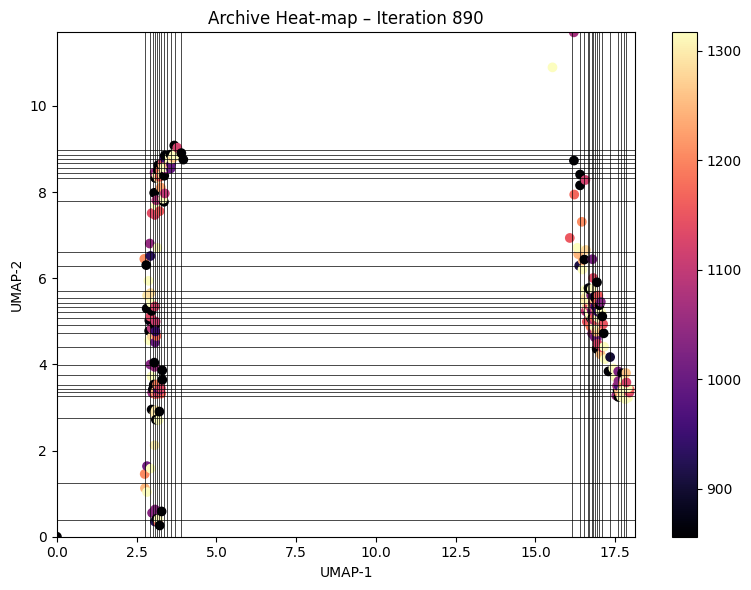

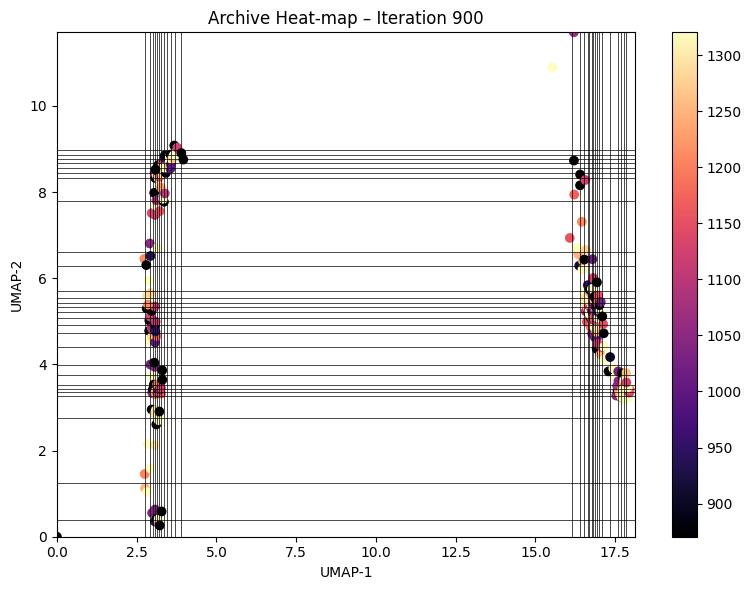

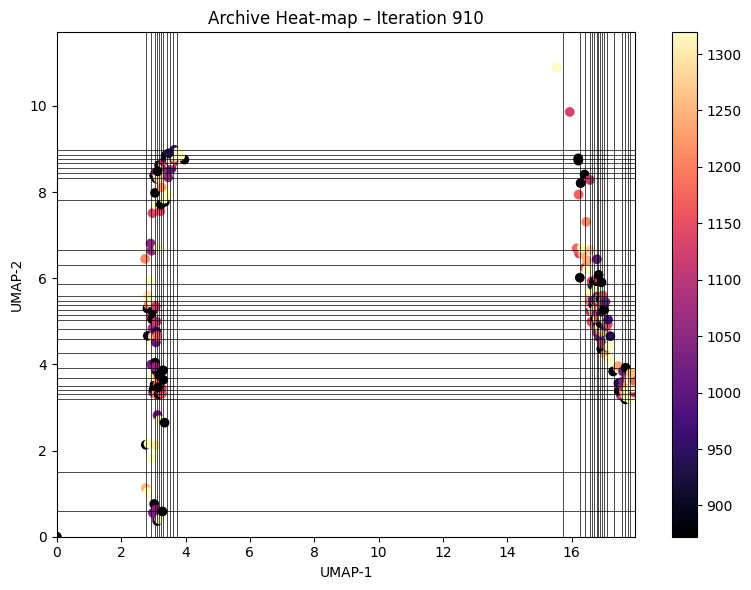

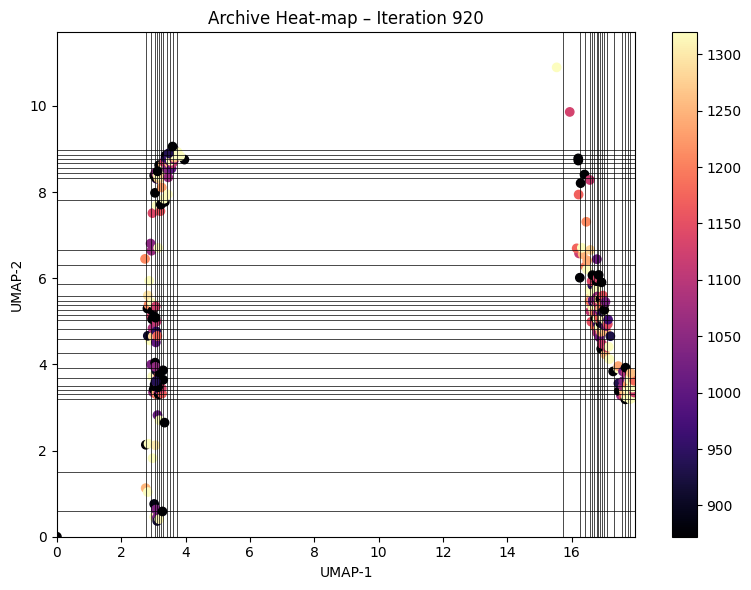

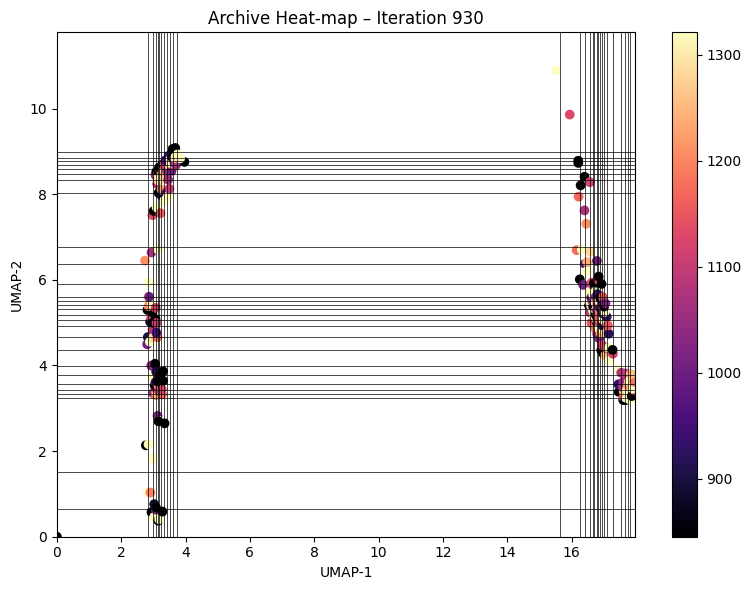

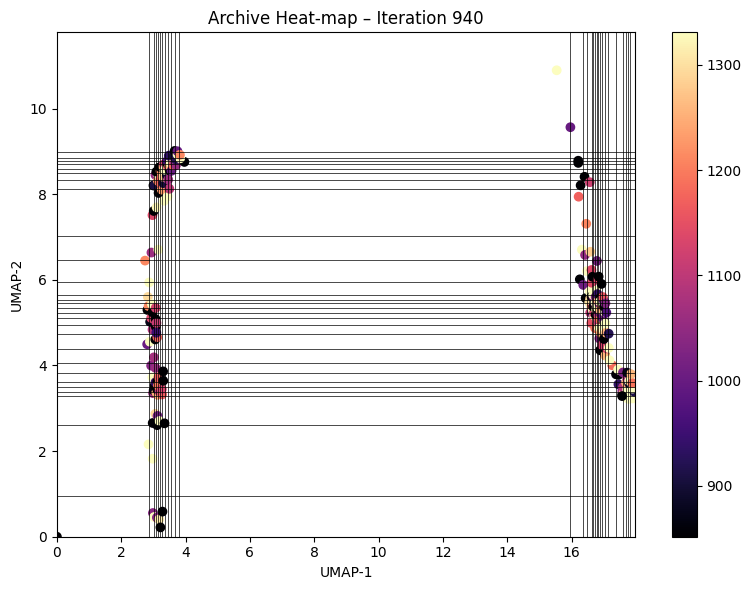

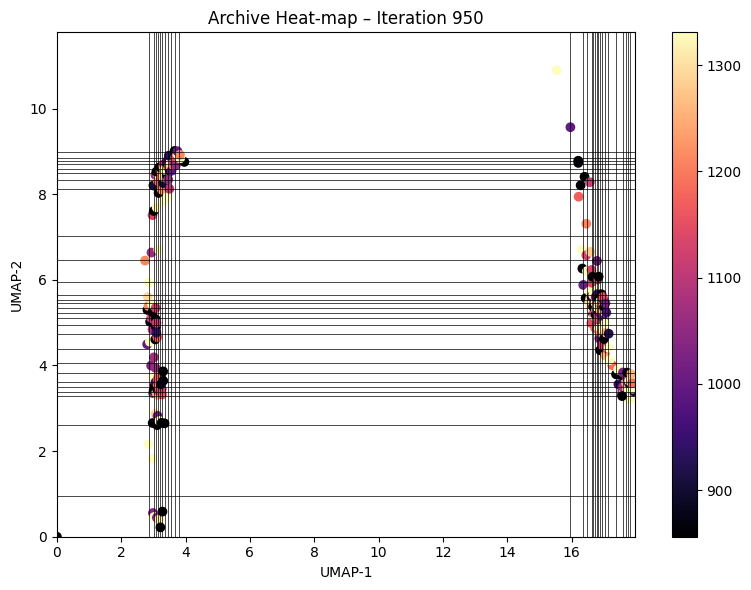

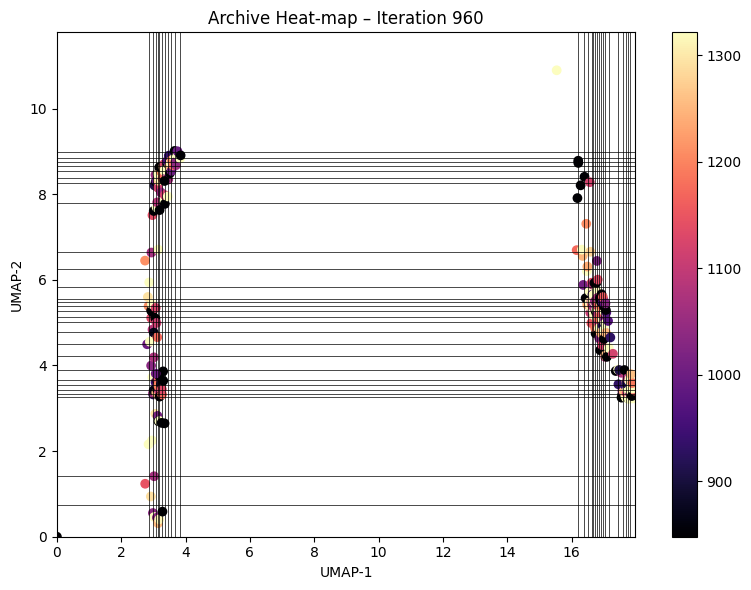

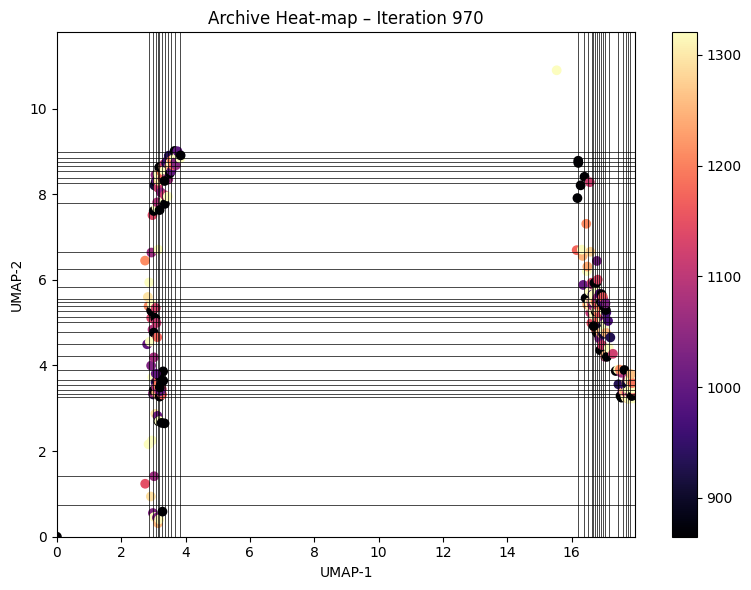

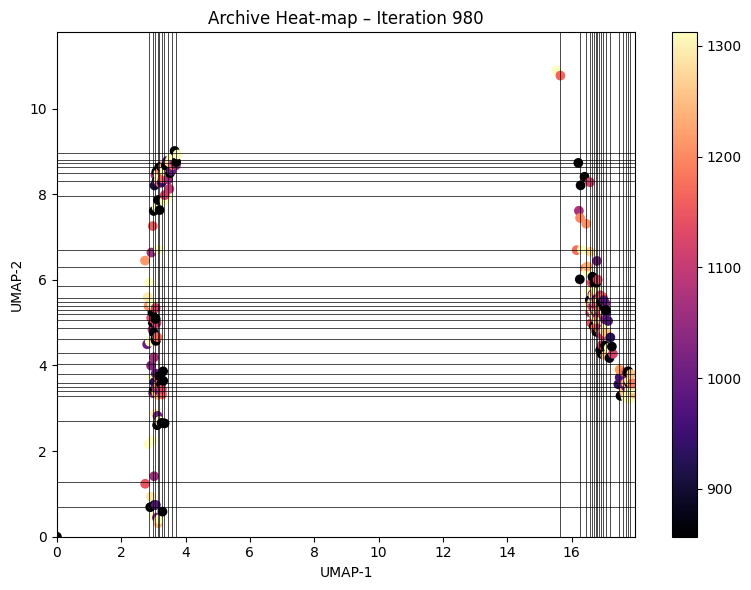

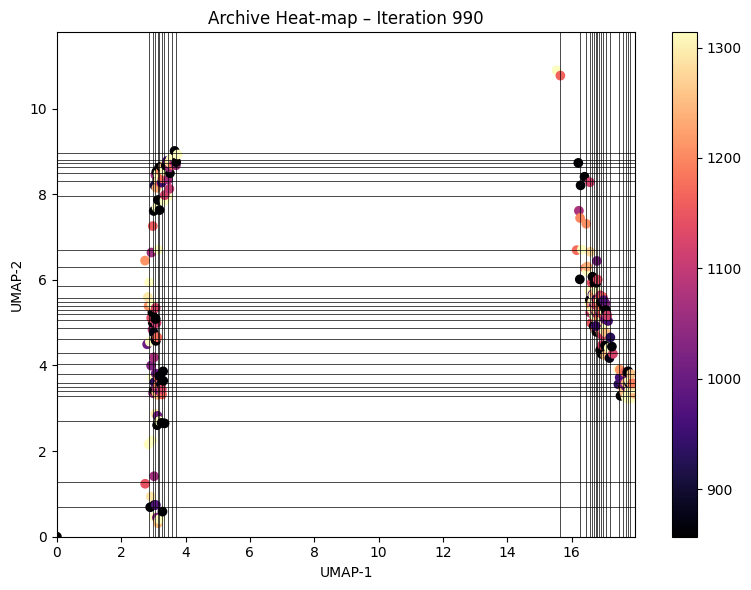

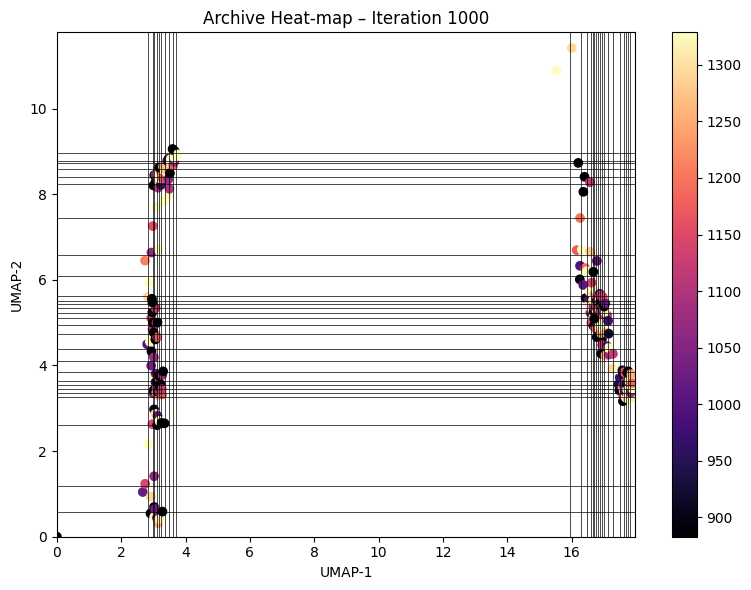

In [17]:
run_map_elites(ITERATIONS, start_iter)

# Visualize results

In [18]:
print(f"Final archive size={len(archive)}, Coverage={archive.stats.coverage:.3f}")
size      = len(archive)
coverage  = archive.stats.coverage
objs      = archive.data()["objective"]
data      = archive.data()

print(f"Archive size     : {size}")
print(f"Coverage         : {coverage:.3%}")
print(f"Best objective   : {objs.max():.3f}")
print(f"Mean objective   : {objs.mean():.3f}\n")

k = 10                                        # how many to list
for i in range(min(k, size)):
    sol_vec = data["solution"][i]
    sol_id  = sol_vec[-1]                     # float ID
    umap_xy = data["measures"][i]
    print(f"{i+1:2d}. "
          f"ID={sol_id:.17f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")




Final archive size=233, Coverage=0.259
Archive size     : 233
Coverage         : 25.889%
Best objective   : 8641.016
Mean objective   : -4290645.552

 1. ID=653.35558772470017175   UMAP=(  0.000,   0.000)
 2. ID=941.52428737273044135   UMAP=(  2.669,   1.045)
 3. ID=871.34990795011503906   UMAP=(  2.744,   1.237)
 4. ID=887.51320152579387468   UMAP=(  2.806,   4.496)
 5. ID=875.27262232970576861   UMAP=(  2.828,   5.600)
 6. ID=482.92587319782336408   UMAP=(  2.740,   6.450)
 7. ID=953.70388428596470476   UMAP=(  2.909,   0.544)
 8. ID=934.29046250943963514   UMAP=(  2.919,   0.940)
 9. ID=896.37012472543892727   UMAP=(  2.849,   2.158)
10. ID=955.60861920418426507   UMAP=(  2.967,   2.629)


 1. ID=788.18660884173266368   dx=  5.535   score=1344.270   UMAP=( 15.535,  10.896)
 2. ID=999.55685089979112945   dx=  6.002   score=1294.719   UMAP=( 16.002,  11.416)
 3. ID=883.35558772470017175   dx=  6.157   score=1173.358   UMAP=( 16.157,   6.694)
 4. ID=262.97389489986869648   dx=  6.208   score= 790.911   UMAP=( 16.208,   8.732)


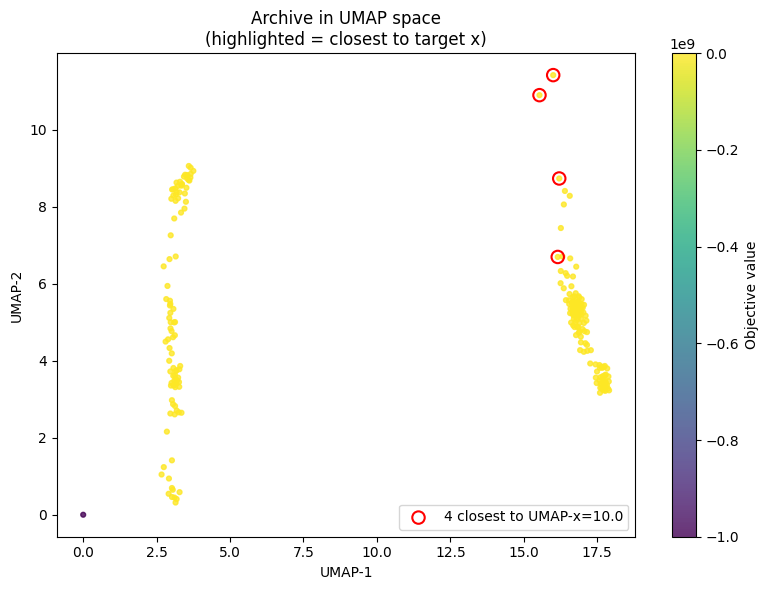

In [19]:
target_x = 10.0   # change this as needed
k        = 4     # how many neighbours to display

measures = data["measures"]                    # (N, 2) array
dx       = np.abs(measures[:, 0] - target_x)   # distance to target on x-axis

nearest_idx = np.argsort(dx)[:k]               # indices of the k closest
for rank, idx in enumerate(nearest_idx, 1):
    sol_vec = data["solution"][idx]
    sol_id  = sol_vec[-1]
    umap_xy = measures[idx]
    score   = objs[idx]
    print(f"{rank:2d}. "
          f"ID={sol_id:.17f}   "
          f"dx={dx[idx]:7.3f}   "
          f"score={score:8.3f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")
    
measures   = data["measures"]            # (N, 2) array of UMAP coordinates
all_x, all_y = measures[:, 0], measures[:, 1]

# colour entire archive by objective score
plt.figure(figsize=(8, 6))
sc = plt.scatter(all_x, all_y,
                 c=objs,                # colour scale = performance
                 s=12,                  # dot size
                 alpha=0.8,
                 cmap="viridis")

# highlight the nearest k in red with black edge
highlight = measures[nearest_idx]
plt.scatter(highlight[:, 0], highlight[:, 1],
            facecolors='none',
            edgecolors='red',
            s=80,
            linewidths=1.5,
            label=f"{len(nearest_idx)} closest to UMAP-x={target_x}")

plt.colorbar(sc, label="Objective value")
plt.title("Archive in UMAP space\n(highlighted = closest to target x)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


 1. ID=824.99755671604054896   score=1062.928   UMAP=(  2.939,   6.638)
 2. ID=942.96989869562708009   score= 894.032   UMAP=(  3.021,   0.694)
 3. ID=817.18660884173266368   score=1319.803   UMAP=( 16.787,   5.055)
 4. ID=916.01676584158474270   score=1187.574   UMAP=( 16.954,   5.392)
 5. ID=932.71998235875321370   score= 819.561   UMAP=(  3.069,   8.289)
 6. ID=972.31793956106810128   score=  77.878   UMAP=( 16.933,   5.358)
 7. ID=646.45016057055386227   score=6781.368   UMAP=( 17.905,   3.230)
 8. ID=921.04849868906569554   score= 729.989   UMAP=( 16.888,   5.496)
 9. ID=209.10519782051187576   score=1624.740   UMAP=(  3.750,   8.929)
10. ID=930.04173378850464360   score= 678.211   UMAP=( 17.482,   3.420)
11. ID=884.99467202908510899   score= 732.306   UMAP=(  3.658,   9.011)
12. ID=923.41600268995159695   score= 931.711   UMAP=( 16.659,   5.217)
13. ID=974.45016057055386227   score=1111.585   UMAP=( 16.887,   5.639)
14. ID=941.56619598845838937   score=1195.360   UMAP=( 16.869,  

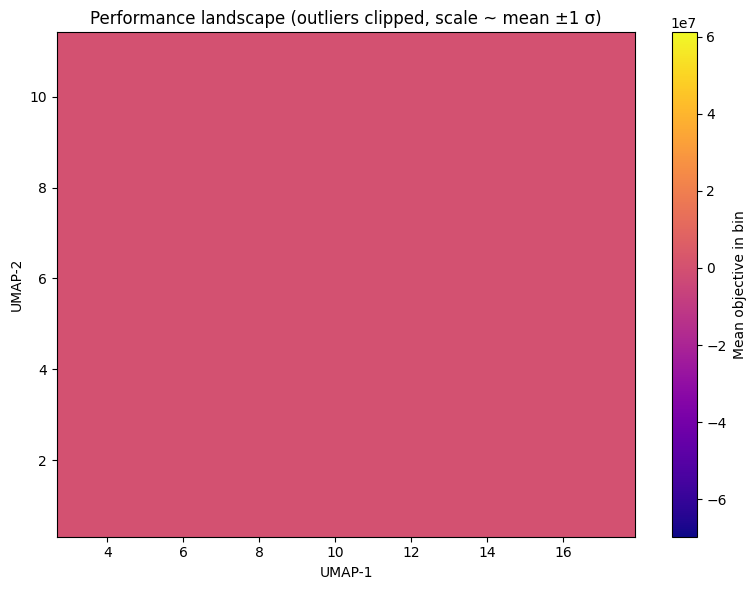

In [20]:
m = 15                                   # how many random elites to inspect
rng = np.random.default_rng(42)          # reproducible
rand_idx = rng.choice(len(archive), size=m, replace=False)

samples = []                             # keep the decoded solutions here
for j, idx in enumerate(rand_idx, 1):
    sol_vec = data["solution"][idx]
    sol_id  = sol_vec[-1]
    umap_xy = data["measures"][idx]
    score   = objs[idx]
    print(f"{j:2d}. ID={sol_id:.17f}   "
          f"score={score:8.3f}   "
          f"UMAP=({umap_xy[0]:7.3f}, {umap_xy[1]:7.3f})")
    
    # store full dict in `samples` for later, if desired
    samples.append(array_to_solution(sol_vec))


import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------------------------
#   filter out objective outliers (beyond ±3 σ from the mean)
# --------------------------------------------------------------
obj_mean = objs.mean()
obj_std  = objs.std()
lo, hi   = obj_mean - 3*obj_std, obj_mean + 3*obj_std
mask     = (objs >= lo) & (objs <= hi)

x_f, y_f = all_x[mask], all_y[mask]
w_f      = objs[mask]                       # colour = objective value

plt.figure(figsize=(8, 6))
hb = plt.hist2d(x_f, y_f,
                bins=50,
                weights=w_f,
                cmap="plasma",
                vmin=obj_mean - obj_std,    # <<< centre the colour bar
                vmax=obj_mean + obj_std)    #     on the mean range
plt.colorbar(hb[3], label="Mean objective in bin")
plt.title("Performance landscape (outliers clipped, scale ~ mean ±1 σ)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.show()

